In [19]:
import sys,os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import scipy as sp
from scipy.linalg import pinv as spinv
from sklearn.metrics import pairwise_distances

In [20]:
def operators(s,RBM=0):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    if RBM==0:
        out = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))
    else:
        out = np.zeros((n_seq,n_var+(n_var-RBM)*RBM))
    jindex = 0
    for index in range(n_var):
        out[:,jindex] = s[:,index]
        jindex +=1
    if RBM==0:
        for index in range(n_var-1):
            for index1 in range(index+1,n_var):
                out[:,jindex] = s[:,index]*s[:,index1]
                jindex +=1
    else:
        for index in range(n_var-RBM):
            for index1 in range(n_var-RBM,n_var):
                out[:,jindex] = s[:,index]*s[:,index1]
                jindex +=1
    return out
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)#/np.power(w.shape[0],0.25)
def energy(w,seqs):
    return np.mean(seqs*seqs.dot(w),axis=1)
def generate_seqs(n_var,n_seq,n_sample=30,large=False,num_large=4,RBM=0):
    samples = np.random.choice([1.0,-1.0],size=n_var*n_seq*n_sample,replace=True).reshape(n_seq*n_sample,n_var)
    ops = operators(samples,RBM=RBM)
    n_ops = ops.shape[1]
##    w_true = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    w_true = (np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
#     if RBM > 0: w_true[n_var:] *= np.sqrt(float(n_var))
    if large and num_large>0: #putting in some large couplings
        indices_large = np.random.choice(range(n_var,n_ops),size=num_large,replace=False)
        for l_index in range(num_large):
            w_true[indices_large[l_index]] *= 10.0

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p = p/np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    return w_true,samples[out_samples],p[out_samples],sample_energy[out_samples]

In [21]:
n_var,n_seq = 60,6000
np.random.seed(0)
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq)

In [13]:
def s_machine(w,s,eps_scale=.01,max_iter=351,alpha=0.1,cov=False,second_order=False):
    n_seq,n_var = s.shape
    ops = operators(s)
    ops_cov0 = np.cov(ops,rowvar=False,bias=True)
    cov_inv = spinv(ops_cov0)
    if cov:
        cov_inv = spinv(ops_cov0)
    else: 
        cov_inv = np.eye(ops.shape[1])

    pair_dist = pairwise_distances(s,metric='cityblock')
    pair_dist0 = pair_dist == 0.0
    num_nbrs = np.zeros(pair_dist.shape)
    num_nbrs[pair_dist0] = 1.0
    ln_num_nbrs = np.log(num_nbrs.sum(axis=1))
    pair_dist,pair_dist0,num_nbrs = 0,0,0
    if second_order: # made results worse
        n_partition=100
        samples_part = np.random.choice([1.0,-1.0],size=n_var*n_seq*n_partition,replace=True).reshape(n_seq*n_partition,n_var)
        ops_model = operators(samples_part)
        ops_model -= np.mean(ops_model,axis=0)[np.newaxis,:]

    for iterate in range(max_iter):
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
#        probs_w = np.exp(-energies_w)

        probs_w /= np.sum(probs_w)
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        if iterate%int(max_iter/5.0)==0: 
            ops_cov_w = np.cov(ops,rowvar=False,bias=True,ddof=0,aweights=probs_w)

            spin_cov_w = np.cov(s,rowvar=False,bias=True,ddof=0,aweights=probs_w)

            print(eps_scale,iterate,nplin.norm(w-w_true),nplin.norm(ops_cov_w-np.eye(ops.shape[1])),\
                  nplin.norm(spin_cov_w-np.eye(n_var)))

        sec_order = w*eps_scale #np.mean(Delta[:,np.newaxis]*ops_model,axis=0)

        if second_order:
        #second order strong coupling
            Delta = eps_scale*ops_model.dot(w)
            Delta -= np.mean(Delta)
            sec_order += 0.5*np.mean((Delta*Delta)[:,np.newaxis]*ops_model,axis=0)

        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
    print('final ',eps_scale,iterate,nplin.norm(w-w_true))


#        w += alpha*((ops_expect_w - sec_order))

    
## Minimizing tr(cov-1)**2
#        spin_expect_w = np.sum(probs_w[:,np.newaxis]*s,axis=0)
#        delta_spin_w = s - spin_expect_w[np.newaxis,:]
#        delta_ops_expect_w = ops - ops_expect_w[np.newaxis,:]
#        c_spin_spin = np.sum(delta_spin_w*delta_spin_w.dot(spin_cov_w-np.eye(n_var)),axis=1)
#        w += alpha*spinv(ops_cov0).dot(np.sum(delta_ops_expect_w*(probs_w*c_spin_spin)[:,np.newaxis],axis=0))
#        w += alpha*(np.sum(delta_ops_expect_w*(probs_w*c_spin_spin)[:,np.newaxis],axis=0))
## Minimizing the KL divergence
#        nbrs_mean = np.sum(ln_num_nbrs*probs_w)
#        nbrs_ops = np.sum(ops*(probs_w*(ln_num_nbrs-nbrs_mean))[:,np.newaxis],axis=0)
#        w -= alpha*cov_inv.dot((ops_cov_w.dot(w) - nbrs_ops - eps_scale*ops_expect))

    

In [11]:
def boltzmann_machine(w,s,max_iter=351,n_partition=10,alpha=5e-2,cov=False):
    n_seq,n_var = s.shape
    ops = operators(s)
    ops_cov0 = np.cov(ops,rowvar=False,bias=True)
    if cov:
        cov_inv = spinv(ops_cov0)
    else: 
        cov_inv = np.eye(ops.shape[1])

    ops_obs = np.mean(ops,axis=0)
    spin_cov_obs = np.cov(s,rowvar=False,bias=True,ddof=0)
    samples_part = np.random.choice([1.0,-1.0],size=n_var*n_seq*n_partition,replace=True).reshape(n_seq*n_partition,n_var)
    ops_model = operators(samples_part)

    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        if iterate%int(max_iter/5.0)==0: 
            spin_cov_w = np.cov(samples_part,rowvar=False,bias=True,ddof=0,aweights=probs_w)
            ops_cov_w = np.cov(ops_model,rowvar=False,bias=True,ddof=0,aweights=probs_w)
            print(iterate,nplin.norm(w-w_true),nplin.norm(spin_cov_w-spin_cov_obs))
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))
    print('final ',iterate,nplin.norm(w-w_true))


In [215]:
for n_part in range(1000,6001,1000):
    print('n_seq ',n_part)
    print('epsilon ')
    for eps in [0.05,0.1,0.2,0.3]:
#         np.random.seed(13)
#         w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
#         s_machine(w_trial,seqs[:n_part],eps_scale=eps)
#         print('without second order')
        np.random.seed(13)
        w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        s_machine(w_trial,seqs[:n_part],eps_scale=eps,cov=False)
    np.random.seed(13)
    w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
 
    print('Boltzmann ')
    boltzmann_machine(w_trial,seqs[:n_part],cov=False)

n_seq  1000
epsilon 
0.05 0 17.53157023769792 211.99261176048904 7.77794536513813
0.05 70 10.62567159852672 76.37314487364881 2.6460598170963516
0.05 140 13.636272706684322 77.94014532153561 2.588364843892935
0.05 210 17.66689093187793 78.62252102027605 2.5766743174069098
0.05 280 20.89475753901242 78.94494263246995 2.5724027138117687
0.05 350 23.27286942065542 79.10769431304601 2.570427269151631
final  0.05 350 23.301540761837426
0.1 0 17.53157023769792 196.13454027850958 7.288660781068911
0.1 70 9.253753409237518 73.46160993970925 2.66763576923355
0.1 140 9.914576447454246 74.43893010831673 2.6251342874270915
0.1 210 11.149596169418166 74.77052363240273 2.6174826088806324
0.1 280 11.903786367109232 74.88617136460458 2.615104080354554
0.1 350 12.302886152708727 74.92876548113458 2.61423136872959
final  0.1 350 12.306866836985552
0.2 0 17.53157023769792 166.58353213206723 6.390045276878316
0.2 70 8.50333863864484 69.32320310822656 2.7397471290477906
0.2 140 8.113020091874436 69.6757246

0.1 70 7.207051897030822 38.95465106074267 1.8272372759560607
0.1 140 5.604707930694171 40.13550739623036 1.6554069115470489
0.1 210 5.472464771501872 40.710972227638315 1.618858887841713
0.1 280 5.512570158409512 40.92810867873974 1.606897285732388
0.1 350 5.547694064088622 41.01257930003319 1.6023910942294535
final  0.1 350 5.548065946845547
0.2 0 17.53157023769792 95.66877573096748 4.7241583092445
0.2 70 7.655413960690007 35.69277715829943 2.011669460839145
0.2 140 6.908596293018876 35.900373557161565 1.9422680241391457
0.2 210 6.814779354693961 35.95696454284057 1.9345232086642496
0.2 280 6.798531871910588 35.966361080490145 1.9333033955723655
0.2 350 6.79540942214108 35.967995093164674 1.9330893687263606
final  0.2 350 6.795391756758379
0.3 0 17.53157023769792 78.4124944728585 4.2176838209243455
0.3 70 8.378436852529045 34.76723572491162 2.1949474827507363
0.3 140 8.085096608958485 34.76141911456795 2.167437258433097
0.3 210 8.064281366821152 34.76424344865495 2.1659164960519797
0

In [216]:
for n_part in range(2500,6001,1000):
    print('n_seq ',n_part)
    print('epsilon ')
    for eps in [0.05,0.1,0.2,0.3]:
        np.random.seed(13)
        w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        s_machine(w_trial,seqs[:n_part],eps_scale=eps,cov=True)
    np.random.seed(13)
    w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
 
    print('Boltzmann ')
    boltzmann_machine(w_trial,seqs[:n_part],cov=True)

n_seq  2500
epsilon 
0.05 0 17.53157023769792 158.43884656229824 6.575812973375196
0.05 70 15.27273240932497 60.22466126989694 2.26832564275738
0.05 140 15.81407130393193 59.68051529953147 1.9575783400655693
0.05 210 16.22893288425698 59.71269368743746 1.8796236717700991
0.05 280 16.530728490873436 59.767996575665705 1.8503551428105072
0.05 350 16.751315246640683 59.81472852976078 1.8362892161578892
final  0.05 350 16.75400553630418
0.1 0 17.53157023769792 144.10026306581648 6.106497122360631
0.1 70 8.277428327499644 54.254781850457704 2.326778716377974
0.1 140 7.711517738919499 53.20069004792053 2.041457773342334
0.1 210 7.6353943014167935 53.24975554946049 1.9824288027774404
0.1 280 7.631726561691947 53.33685817745023 1.9638584106408223
0.1 350 7.639506637955473 53.400173217874105 1.9560725796384713
final  0.1 350 7.6396294618504825
0.2 0 17.53157023769792 118.89655912271738 5.3036525721077314


/Users/vipulp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/vipulp/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3077: RuntimeWarning: invalid value encountered in less
  if any(aweights < 0):


0.2 70 nan nan nan
0.2 140 nan nan nan
0.2 210 nan nan nan
0.2 280 nan nan nan
0.2 350 nan nan nan
final  0.2 350 nan
0.3 0 17.53157023769792 98.3768302340173 4.6682385257178804
0.3 70 nan nan nan
0.3 140 nan nan nan
0.3 210 nan nan nan
0.3 280 nan nan nan
0.3 350 nan nan nan
final  0.3 350 nan
Boltzmann 
0 17.53157023769792 4.422487082785222
70 11.201661619884794 2.337706943120727
140 10.949445312163403 1.890511511905016
210 11.570206049996301 1.6226467782456602
280 12.567324717950857 1.4434903408292563
350 13.741983140237236 1.3166200416636584
final  350 13.759517981418089
n_seq  3500
epsilon 
0.05 0 17.53157023769792 165.74432082793655 6.740219328537001
0.05 70 12.132842678820206 53.482524496966874 2.0594091305522135
0.05 140 12.500296736873425 53.22109629414861 1.7277189901928898
0.05 210 12.878436579200644 53.41490449679101 1.6433428824036689
0.05 280 13.153891242280887 53.59713080651677 1.6112536874941608
0.05 350 13.350914448407599 53.72833420362682 1.5955997488691098
final  0.0

In [326]:
n_var,n_seq = 60,6000
np.random.seed(0)
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq)

In [15]:
#negative samples generated by demanding that configurations not close to the observed configurations should have low probability
def eps_machine(w,s,eps_scale=.01,max_iter=351,alpha=0.1,cov=False,frac_false=0.1):
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    ops_cov0 = np.cov(ops,rowvar=False,bias=True)
    cov_inv = spinv(ops_cov0)
    if cov:
        cov_inv = spinv(ops_cov0)
    else: 
        cov_inv = np.eye(ops.shape[1])

    for iterate in range(max_iter):
        obs_energies_w = energy_ops(ops,w)
        obs_energies_min = np.min(obs_energies_w)
#         n_sample,n_false = 1,int(frac_false*iterate)+1 #for false sequences

#         false_samples = np.random.choice([1.0,-1.0],size=n_var*n_seq*n_sample,replace=True).reshape(n_seq*n_sample,n_var)
#         pair_dist = pairwise_distances(s,false_samples,metric='cityblock')
#         false_total_dist = np.min(pair_dist,axis=0)
#         false_dist_order = np.argsort(false_total_dist)[-n_false:] #the farthest away from observed sequences
#         false_samples = false_samples[false_dist_order,:]
#         false_ops = operators(false_samples)
#         false_energies_w = energy_ops(false_ops,w)
#         false_energies_wrong = np.logical_and(false_energies_w > 0,false_energies_w > obs_energies_min)
#         false_ops = false_ops[false_energies_wrong]
#         false_energies_w = np.minimum(-false_energies_w[false_energies_wrong],\
#                                       obs_energies_min-false_energies_w[false_energies_wrong])
#         n_false = false_ops.shape[0]
#         #make the wrong predictions less likely

#         energies_w = np.vstack((obs_energies_w.reshape(n_seq,1),false_energies_w.reshape(n_false,1)))
        energies_w = obs_energies_w.reshape(n_seq,1)
#         probs_w = np.exp(-energies_w*(1-eps_scale)).reshape(n_false+n_seq)

        probs_w = np.exp(-energies_w*(1-eps_scale)).reshape(n_seq)

        probs_w /= np.sum(probs_w)
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops.reshape(n_seq,n_ops),axis=0)
#         ops_expect_w = np.sum(probs_w[:,np.newaxis]*np.vstack((ops.reshape(n_seq,n_ops),\
#                                                                false_ops.reshape(n_false,n_ops))),axis=0)
        if iterate%int(max_iter/5.0)==0: 
            print(eps_scale,iterate,nplin.norm(w-w_true))

#             print(eps_scale,iterate,nplin.norm(w-w_true),'n_false =',n_false)

        sec_order = w*eps_scale

        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
    print('final ',eps_scale,iterate,nplin.norm(w-w_true))



n_seq  3600
rbm 
0.01 0 12.598757692591706
0.01 36 9.095393194007205
0.01 72 8.69617782354869
0.01 108 9.744911382359145
0.01 144 11.323446757042275
final  0.01 179 13.09515881465077
0.05 0 12.598757692591706
0.05 36 7.712379638220476
0.05 72 6.586078735881724
0.05 108 6.95232022534349
0.05 144 7.707582467194342
final  0.05 179 8.50073538575866
0.1 0 12.598757692591706
0.1 36 6.234308055515265
0.1 72 4.72945443902498
0.1 108 4.79043343449566
0.1 144 5.12736378767184
final  0.1 179 5.437955451639232


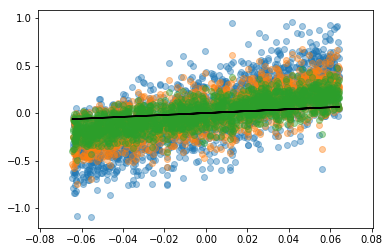

n_seq  5100
rbm 
0.01 0 12.598757692591706
0.01 36 8.525427016163936
0.01 72 7.637711782527221
0.01 108 8.250167724068914
0.01 144 9.429184378090952
final  0.01 179 10.813584021950057
0.05 0 12.598757692591706
0.05 36 7.195917150910766
0.05 72 5.691684566701848
0.05 108 5.7909449091216745
0.05 144 6.331323856611503
final  0.05 179 6.924860375820355
0.1 0 12.598757692591706
0.1 36 5.815448435464978
0.1 72 4.023016119690483
0.1 108 3.9458912257515673
0.1 144 4.17384696380334
final  0.1 179 4.388352535620621


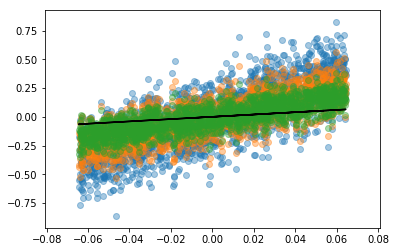

n_seq  6600
rbm 
0.01 0 12.598757692591706
0.01 36 8.157690082366626
0.01 72 6.8795537386902845
0.01 108 7.169342107573645
0.01 144 8.012920371450864
final  0.01 179 9.033885866071472
0.05 0 12.598757692591706
0.05 36 6.810654805941745
0.05 72 5.026396941819932
0.05 108 4.925285261923259
0.05 144 5.248576773576423
final  0.05 179 5.6333391868664755
0.1 0 12.598757692591706
0.1 36 5.407222856002093
0.1 72 3.47370973517833
0.1 108 3.289889930094575
0.1 144 3.3996158670426997
final  0.1 179 3.5193881677803787


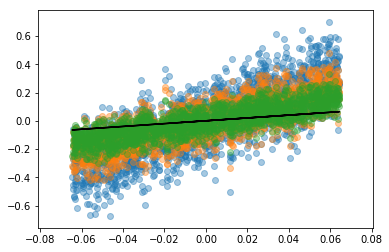

n_seq  8100
rbm 
0.01 0 12.598757692591706
0.01 36 7.64171686333805
0.01 72 6.129459265764968
0.01 108 6.1801622586170675
0.01 144 6.770336550070418
final  0.01 179 7.532299550873893
0.05 0 12.598757692591706
0.05 36 6.38200667598666
0.05 72 4.430902177037757
0.05 108 4.186102027259701
0.05 144 4.373596402643774
final  0.05 179 4.628134621448694
0.1 0 12.598757692591706
0.1 36 5.064900424167567
0.1 72 3.0236707084011747
0.1 108 2.771635020698035
0.1 144 2.8174348662021957
final  0.1 179 2.8817721894287205


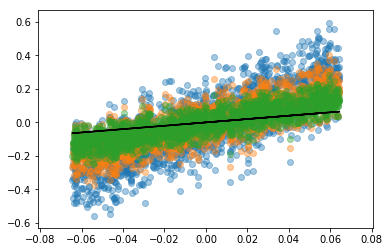

n_seq  9600
rbm 
0.01 0 12.598757692591706
0.01 36 7.378450439618887
0.01 72 5.710891419118852
0.01 108 5.6084482506737094
0.01 144 6.030617597913654
final  0.01 179 6.611818893738071
0.05 0 12.598757692591706
0.05 36 6.146278342504686
0.05 72 4.087584947472797
0.05 108 3.751523968164076
0.05 144 3.842506616928013
final  0.05 179 4.005169101788089
0.1 0 12.598757692591706
0.1 36 4.874155523194474
0.1 72 2.7651045817672006
0.1 108 2.464211294678011
0.1 144 2.4646932037796354
final  0.1 179 2.494668762821002


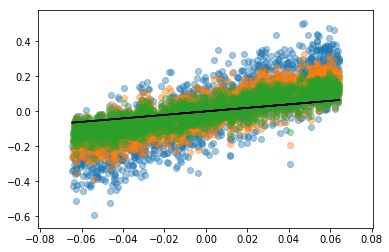

In [94]:
n_var,n_seq = 60,10000
np.random.seed(0)
RBM0=0

w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)
for n_part in range(3600,10001,1500):
    print('n_seq ',n_part)
    print('rbm ')
    for eps in [0.01,0.05,0.1]:
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.random.rand(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
        eps_machine(w_trial,seqs[:n_part],max_iter=180,eps_scale=eps,cov=False)

        plt.scatter(w_true,w_trial,alpha=0.4)
    plt.plot(w_true,w_true,'k')
    plt.show()
    plt.close()


In [328]:
for n_part in range(1000,6001,1000):
    print('n_seq ',n_part)
    print('epsilon ')
    for eps in [0.05,0.1,0.2,0.3]:
        np.random.seed(13)
        w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        eps_machine(w_trial,seqs[:n_part],eps_scale=eps,cov=False)
    np.random.seed(13)
    w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
 
    print('Boltzmann ')
    boltzmann_machine(w_trial,seqs[:n_part],cov=False)


n_seq  1000
epsilon 
0.05 0 17.53157023769792 n_false = 0
0.05 70 10.756450662974025 n_false = 0
0.05 140 17.70443737789329 n_false = 0
0.05 210 28.966954449458537 n_false = 4
0.05 280 42.217293829181045 n_false = 15
0.05 350 54.04036530945765 n_false = 17
final  0.05 350 54.409879868977384
0.1 0 17.53157023769792 n_false = 0
0.1 70 9.289474376468256 n_false = 0
0.1 140 10.420879166735684 n_false = 0
0.1 210 16.355364738357355 n_false = 0
0.1 280 27.073957374307348 n_false = 9
0.1 350 36.53425090520913 n_false = 20
final  0.1 350 36.618211613605794
0.2 0 17.53157023769792 n_false = 0
0.2 70 8.512274965968206 n_false = 0
0.2 140 8.119636650696062 n_false = 0
0.2 210 8.180288109377692 n_false = 0
0.2 280 8.136971130698479 n_false = 1
0.2 350 8.243245919849684 n_false = 1
final  0.2 350 8.242574925229722
0.3 0 17.53157023769792 n_false = 0
0.3 70 8.776195475595708 n_false = 0
0.3 140 8.524399052362405 n_false = 0
0.3 210 8.516297401136105 n_false = 0
0.3 280 8.504008225596117 n_false = 1


KeyboardInterrupt: 

In [330]:
# try out new version of eps-machine with np.minimum instead of just -false_energies_w
n_var,n_seq = 20,1000
np.random.seed(0)
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq)

for n_part in range(150,1001,250):
    print('n_seq ',n_part)
    print('epsilon ')
    for eps in [0.05,0.1,0.2,0.3]:
        np.random.seed(13)
        w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        eps_machine(w_trial,seqs[:n_part],eps_scale=eps,cov=False)
    np.random.seed(13)
    w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
 
    print('Boltzmann ')
    boltzmann_machine(w_trial,seqs[:n_part],cov=False)



n_seq  150
epsilon 
0.05 0 6.055707687261436 n_false = 0
0.05 70 6.4480245766946895 n_false = 1
0.05 140 13.060813582532239 n_false = 2
0.05 210 27.21606941134735 n_false = 5
0.05 280 42.8444026885621 n_false = 14
0.05 350 55.25952560139365 n_false = 17
final  0.05 350 55.25348641465683
0.1 0 6.055707687261436 n_false = 0
0.1 70 5.33728611175032 n_false = 1
0.1 140 8.04559003852078 n_false = 2
0.1 210 17.145915279642253 n_false = 4
0.1 280 28.963752435972577 n_false = 12
0.1 350 35.993354543086866 n_false = 13
final  0.1 350 36.07838742600307
0.2 0 6.055707687261436 n_false = 0
0.2 70 4.068007094408589 n_false = 1
0.2 140 4.605633585897911 n_false = 1
0.2 210 4.940606734874902 n_false = 3
0.2 280 5.369720022673432 n_false = 4
0.2 350 9.928451291942093 n_false = 8
final  0.2 350 9.889752890704845
0.3 0 6.055707687261436 n_false = 0
0.3 70 3.480737989977251 n_false = 1
0.3 140 3.564819431718371 n_false = 2
0.3 210 3.591205161460612 n_false = 3
0.3 280 3.626977725663765 n_false = 9
0.3 35

In [12]:
#with some large couplings in w
n_var,n_seq = 20,1000
np.random.seed(0)
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=True,num_large=4)

for n_part in range(150,1001,250):
    print('n_seq ',n_part)
    print('epsilon ')
    for eps in [0.05,0.1,0.2,0.3]:
        np.random.seed(13)
        w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        eps_machine(w_trial,seqs[:n_part],eps_scale=eps,cov=False)
    print('s ')
    for eps in [0.05,0.1,0.2,0.3]:
        np.random.seed(13)
        w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
        s_machine(w_trial,seqs[:n_part],eps_scale=eps,cov=False)

    np.random.seed(13)
    w_trial = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
 
    print('Boltzmann ')
    boltzmann_machine(w_trial,seqs[:n_part],cov=False)



n_seq  150
epsilon 
0.05 0 8.128686829980452 n_false = 0
0.05 70 6.285960855463716 n_false = 1
0.05 140 10.691559934479953 n_false = 0
0.05 210 16.800502899948242 n_false = 9
0.05 280 26.445564356939595 n_false = 8
0.05 350 38.19395813051057 n_false = 12
final  0.05 350 38.655903485711335
0.1 0 8.128686829980452 n_false = 0
0.1 70 5.4064514266803 n_false = 1
0.1 140 7.592259985480928 n_false = 0
0.1 210 11.906565458716921 n_false = 8
0.1 280 20.673223956368435 n_false = 13
0.1 350 28.33549992635018 n_false = 13
final  0.1 350 28.660451463223303
0.2 0 8.128686829980452 n_false = 0
0.2 70 4.583157224117553 n_false = 1
0.2 140 4.872572333553164 n_false = 0
0.2 210 5.188924416347627 n_false = 1
0.2 280 6.14861396969551 n_false = 3
0.2 350 14.374591455450052 n_false = 16
final  0.2 350 14.417004200719376
0.3 0 8.128686829980452 n_false = 0
0.3 70 4.40825308964666 n_false = 1
0.3 140 4.339657387532344 n_false = 0
0.3 210 4.346696218615077 n_false = 1
0.3 280 4.3972739109386945 n_false = 2
0.

In [16]:
def eps_machine_rbm(w,s,eps_scale=.01,max_iter=50,alpha=0.1,cov=False,RBM=0):
    n_seq,n_var = s.shape
    ops = operators(s,RBM=RBM)
    n_ops = ops.shape[1]
    print('n_ops',n_ops)
    if RBM>0:
        n_rbm_couplings = (1+n_var-RBM)*RBM
    ops_cov0 = np.cov(ops,rowvar=False,bias=True)
    if cov:
        cov_inv = spinv(ops_cov0)
    else: 
        cov_inv = np.eye(n_ops)

    for iterate in range(max_iter):
        if RBM==0:
#         obs_energies_w = energy_ops(ops,w)
#         obs_energies_min = np.min(obs_energies_w)
#         energies_w = obs_energies_w.reshape(n_seq,1)

#         probs_w = np.exp(-energies_w*(1-eps_scale)).reshape(n_seq)

#         probs_w /= np.sum(probs_w)
#         ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops.reshape(n_seq,n_ops),axis=0)

            obs_energies_w = energy_ops(ops,w)
            sec_order = w*eps_scale
            probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
#            max_obs = np.max(probs_w)

            max_obs=0.0
            probs_w = np.exp(probs_w - max_obs)
            probs_w /= np.sum(probs_w)
            ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)

        elif RBM>0:
            w_iA = w[-n_rbm_couplings+RBM:].reshape((n_var-RBM,RBM))
            v_A = w[n_var-RBM:n_var].reshape((RBM))
            u_i = w[:n_var-RBM].reshape((n_var-RBM))
            w_dot_v = w_iA.dot(v_A)
            u_dot_w = u_i.dot(w_iA)
            u_v = np.outer(u_i,v_A)
            ops_w = ops[:,:n_var-RBM].dot(w_iA)
##            sig_u = ops[:,n_var-RBM]-eps_scale*u_i
##            sig_u_dot_w = sig_u.dot(w_iA)
            combo = v_A[np.newaxis,:] + ops_w
            obs_energies_w = (eps_scale-1)*ops[:,:n_var-RBM].dot(u_i) + np.sum(np.log(np.cosh(eps_scale*(combo))),axis=1)
            obs_energies_w -= np.sum(np.log(np.cosh((combo))),axis=1)
            max_obs = np.max(obs_energies_w)
            probs_w = np.exp(obs_energies_w - max_obs)
            probs_w /= np.sum(probs_w)
            sec_order = np.zeros(n_ops)
            sec_order[:n_var-RBM] = u_i + eps_scale*w_dot_v
            sec_order[n_var-RBM:n_var] = eps_scale*(eps_scale*u_dot_w)
            sec_order[n_var:] = eps_scale*(w_iA + eps_scale*u_v).reshape((n_var-RBM)*RBM)
            sec_order *= eps_scale
            ops_expect_w = np.zeros(n_ops)
            ops_expect_w[:n_var-RBM] = np.sum(probs_w[:,np.newaxis]*ops[:,:n_var-RBM],axis=0)
            ops_expect_w[n_var-RBM:n_var] = np.sum(probs_w[:,np.newaxis]*ops_w,axis=0)*eps_scale
            ops_expect_w[n_var:] = eps_scale*np.dot((probs_w[:,np.newaxis]*ops[:,:n_var-RBM]).T,ops_w).reshape((n_var-RBM)*RBM)
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
        if iterate%(int(max_iter/10)+1)==0: print('eps',eps_scale,'iterate',iterate,nplin.norm(w-w_true))


            
            




n_seq  3600
rbm 
n_ops 210
eps 0.001 iterate 0 4.10767377785269
eps 0.001 iterate 19 1.500040974976864
eps 0.001 iterate 38 0.6226174220135215
eps 0.001 iterate 57 0.4663174289583402
eps 0.001 iterate 76 0.4574960960728846
eps 0.001 iterate 95 0.46001947978007324
eps 0.001 iterate 114 0.46179679425060194
eps 0.001 iterate 133 0.4626485947713399
eps 0.001 iterate 152 0.4630259883067242
eps 0.001 iterate 171 0.4631890517099298
n_ops 210
eps 0.01 iterate 0 4.104141124952169
eps 0.01 iterate 19 1.4692071787217205
eps 0.01 iterate 38 0.6039324698000602
eps 0.01 iterate 57 0.45788556206211145
eps 0.01 iterate 76 0.4507689862414273
eps 0.01 iterate 95 0.4534188439011424
eps 0.01 iterate 114 0.4551418118404575
eps 0.01 iterate 133 0.4559440141850694
eps 0.01 iterate 152 0.45629213425361137
eps 0.01 iterate 171 0.45643986623840616
n_ops 210
eps 0.1 iterate 0 4.069767594076912
eps 0.1 iterate 19 1.2080286009553116
eps 0.1 iterate 38 0.47141796500141797
eps 0.1 iterate 57 0.3955273165461625
eps 0

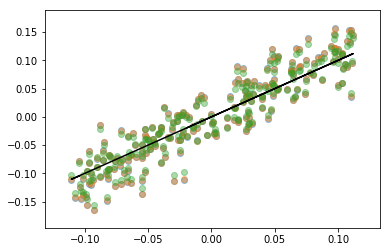

n_seq  5100
rbm 
n_ops 210
eps 0.001 iterate 0 4.123204564851489
eps 0.001 iterate 19 1.4319598799700923
eps 0.001 iterate 38 0.5517657005759973
eps 0.001 iterate 57 0.3966835136305424
eps 0.001 iterate 76 0.3814880184170864
eps 0.001 iterate 95 0.3796709832058826
eps 0.001 iterate 114 0.37935277408222523
eps 0.001 iterate 133 0.3792792371088834
eps 0.001 iterate 152 0.3792598644778275
eps 0.001 iterate 171 0.3792545815901722
n_ops 210
eps 0.01 iterate 0 4.118077943379432
eps 0.01 iterate 19 1.4028683774690174
eps 0.01 iterate 38 0.5364103060262493
eps 0.01 iterate 57 0.3905987442219554
eps 0.01 iterate 76 0.3769351055081066
eps 0.01 iterate 95 0.37538594249965557
eps 0.01 iterate 114 0.375133884692633
eps 0.01 iterate 133 0.3750802505129562
eps 0.01 iterate 152 0.3750673739021128
eps 0.01 iterate 171 0.3750642706679588
n_ops 210
eps 0.1 iterate 0 4.068253381527326
eps 0.1 iterate 19 1.1579595270451128
eps 0.1 iterate 38 0.42772374635031596
eps 0.1 iterate 57 0.34476412278819596
eps 0.

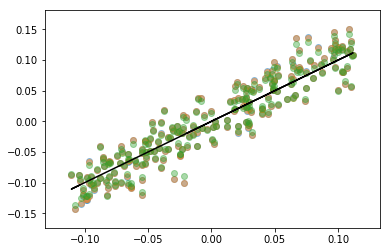

n_seq  6600
rbm 
n_ops 210
eps 0.001 iterate 0 4.1004264972548565
eps 0.001 iterate 19 1.3926553542901512
eps 0.001 iterate 38 0.5083023007121453
eps 0.001 iterate 57 0.36310985524484335
eps 0.001 iterate 76 0.3516281502603523
eps 0.001 iterate 95 0.3506014679131655
eps 0.001 iterate 114 0.35047911212493066
eps 0.001 iterate 133 0.35046384041464657
eps 0.001 iterate 152 0.3504631253075961
eps 0.001 iterate 171 0.35046383663320485
n_ops 210
eps 0.01 iterate 0 4.095718000693272
eps 0.01 iterate 19 1.3646164017028117
eps 0.01 iterate 38 0.494278707303897
eps 0.01 iterate 57 0.35762925690268044
eps 0.01 iterate 76 0.34735781496313517
eps 0.01 iterate 95 0.3465292042042598
eps 0.01 iterate 114 0.3464550537718387
eps 0.01 iterate 133 0.3464536455734324
eps 0.01 iterate 152 0.3464571428033268
eps 0.01 iterate 171 0.34645916046079717
n_ops 210
eps 0.1 iterate 0 4.050707417021869
eps 0.1 iterate 19 1.1288981850704998
eps 0.1 iterate 38 0.3942912066732592
eps 0.1 iterate 57 0.31508345171625235
e

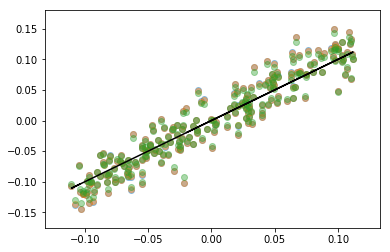

n_seq  8100
rbm 
n_ops 210
eps 0.001 iterate 0 4.098478821025434
eps 0.001 iterate 19 1.3796786500518452
eps 0.001 iterate 38 0.4689207360350897
eps 0.001 iterate 57 0.3102306451619931
eps 0.001 iterate 76 0.29556727048710313
eps 0.001 iterate 95 0.2934705218967535
eps 0.001 iterate 114 0.29298652631095784
eps 0.001 iterate 133 0.29285292549720787
eps 0.001 iterate 152 0.2928137258886548
eps 0.001 iterate 171 0.29280189578222426
n_ops 210
eps 0.01 iterate 0 4.093856844612848
eps 0.01 iterate 19 1.351984206922996
eps 0.01 iterate 38 0.4555336358453089
eps 0.01 iterate 57 0.3056778902572741
eps 0.01 iterate 76 0.2922897477625504
eps 0.01 iterate 95 0.2904186801720146
eps 0.01 iterate 114 0.289995005086628
eps 0.01 iterate 133 0.2898797524094369
eps 0.01 iterate 152 0.2898463304816678
eps 0.01 iterate 171 0.28983634419449794
n_ops 210
eps 0.1 iterate 0 4.049997255907154
eps 0.1 iterate 19 1.1191806419254422
eps 0.1 iterate 38 0.3603985478350509
eps 0.1 iterate 57 0.27043932545340865
eps 0

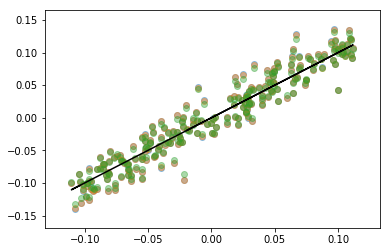

n_seq  9600
rbm 
n_ops 210
eps 0.001 iterate 0 4.0958904883913085
eps 0.001 iterate 19 1.3597159284346083
eps 0.001 iterate 38 0.43002325073453945
eps 0.001 iterate 57 0.2694372029941012
eps 0.001 iterate 76 0.25703806030695536
eps 0.001 iterate 95 0.25578085547767443
eps 0.001 iterate 114 0.2555762224433453
eps 0.001 iterate 133 0.2555352230444332
eps 0.001 iterate 152 0.2555264834073416
eps 0.001 iterate 171 0.2555246067144821
n_ops 210
eps 0.01 iterate 0 4.091388521852506
eps 0.01 iterate 19 1.3324484077949934
eps 0.01 iterate 38 0.4174243724075748
eps 0.01 iterate 57 0.2656657257159725
eps 0.01 iterate 76 0.2543597804004004
eps 0.01 iterate 95 0.25325711205792684
eps 0.01 iterate 114 0.25308753105049936
eps 0.01 iterate 133 0.25305584593360614
eps 0.01 iterate 152 0.253049679590426
eps 0.01 iterate 171 0.25304852117397353
n_ops 210
eps 0.1 iterate 0 4.0489441144609515
eps 0.1 iterate 19 1.1033182110615898
eps 0.1 iterate 38 0.3286784504280665
eps 0.1 iterate 57 0.23671470841596715


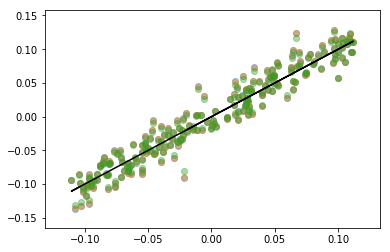

In [7]:
n_var,n_seq = 20,10000
np.random.seed(0)
RBM0=0

w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)
for n_part in range(3600,10001,1500):
    print('n_seq ',n_part)
    print('rbm ')
    for eps in [0.001,0.01,0.1]:
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.random.rand(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
#        eps_machine_rbm(w_trial,seqs[:n_part],max_iter=int(50/eps),eps_scale=eps,cov=False,RBM=RBM0)

        eps_machine_rbm(w_trial,seqs[:n_part],max_iter=180,eps_scale=eps,cov=False,RBM=RBM0)

        plt.scatter(w_true,w_trial,alpha=0.4)
    plt.plot(w_true,w_true,'k')
    plt.show()
    plt.close()


In [46]:
def eps_machine_rbm2(w,s,eps_scale=.01,max_iter=50,alpha=0.1,cov=False,RBM=0):
    """trying nonlinear exact forms - didn't work"""
    n_seq,n_var = s.shape
    ops = operators(s,RBM=RBM)
    n_ops = ops.shape[1]
    print('n_ops',n_ops)
    if RBM>0:
        n_rbm_couplings = (1+n_var-RBM)*RBM
        s_temp = np.copy(s)
    ops_cov0 = np.cov(ops,rowvar=False,bias=True)
    if cov:
        cov_inv = spinv(ops_cov0)
    else: 
        cov_inv = np.eye(n_ops)

    for iterate in range(max_iter):
        if RBM==0:
#         obs_energies_w = energy_ops(ops,w)
#         obs_energies_min = np.min(obs_energies_w)
#         energies_w = obs_energies_w.reshape(n_seq,1)

#         probs_w = np.exp(-energies_w*(1-eps_scale)).reshape(n_seq)

#         probs_w /= np.sum(probs_w)
#         ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops.reshape(n_seq,n_ops),axis=0)

            obs_energies_w = energy_ops(ops,w)
            sec_order = np.tanh(w*eps_scale)
            probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
            max_obs = np.max(probs_w)
            probs_w = np.exp(probs_w - max_obs)
            probs_w /= np.sum(probs_w)
            ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        elif RBM>0:
            w_iA = (eps_scale*w[-n_rbm_couplings+RBM:].reshape((n_var-RBM,RBM)))
            v_A = (eps_scale*w[n_var-RBM:n_var].reshape((RBM)))
            u_i = (eps_scale*w[:n_var-RBM].reshape((n_var-RBM)))
#             w_dot_v = np.tanh(w_iA).dot(np.tanh(v_A))
#             u_dot_w = np.tanh(u_i).dot(np.tanh(w_iA))
#             u_v = np.outer(np.tanh(u_i),np.tanh(v_A))

            w_dot_v = (w_iA).dot((v_A))
            u_dot_w = (u_i).dot((w_iA))
            u_v = np.outer((u_i),(v_A))

#             s_temp[:,-RBM:] = np.sign(np.tanh(v_A[np.newaxis,:] + s[:,:n_var-RBM].dot(w_iA)))
#             ops_temp = operators(s_temp,RBM=RBM)
            ops_w = ops[:,:n_var-RBM].dot(w_iA)
##            sig_u = ops[:,n_var-RBM]-eps_scale*u_i
##            sig_u_dot_w = sig_u.dot(w_iA)
            combo = (v_A[np.newaxis,:] + ops_w)
#             obs_energies_w = (eps_scale-1)*ops[:,:n_var-RBM].dot(u_i)/eps_scale + np.sum(np.log(np.cosh((combo))),axis=1)

            obs_energies_w = (eps_scale-1)*ops[:,:n_var-RBM].dot(u_i)/eps_scale + \
                                np.sum(0.5*combo**2,axis=1)

            obs_energies_w -= np.sum(np.log(np.cosh((combo/eps_scale))),axis=1)
#             obs_energies_w = energy_ops(ops_temp,w)
            max_obs = np.max(obs_energies_w)
            probs_w = np.exp(obs_energies_w - max_obs)
            probs_w /= np.sum(probs_w)
            sec_order = np.zeros(n_ops)
#             sec_order[:n_var-RBM] = np.tanh(u_i) + w_dot_v/np.cosh(u_i)**2
#             sec_order[n_var-RBM:n_var] = np.tanh(v_A) + (u_dot_w)/np.cosh(v_A)**2
#             sec_order[n_var:] = (np.tanh(w_iA) + u_v/np.cosh(w_iA)**2).reshape((n_var-RBM)*RBM)

            sec_order[:n_var-RBM] = (u_i+ w_dot_v)#*(1.0-0.5*(u_i)**2)
            sec_order[n_var-RBM:n_var] = (u_dot_w)#*(1.0-0.5*(v_A)**2)
            sec_order[n_var:] = ((w_iA+ u_v) ).reshape((n_var-RBM)*RBM)#*(1.0-0.5*(w_iA)**2)).reshape((n_var-RBM)*RBM)

#             sec_order *= eps_scale
#             ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops_temp,axis=0)

            ops_expect_w = np.zeros(n_ops)
            ops_expect_w[:n_var-RBM] = np.sum(probs_w[:,np.newaxis]*ops[:,:n_var-RBM],axis=0)
#             ops_expect_w[n_var-RBM:n_var] = np.sum(probs_w[:,np.newaxis]*np.tanh(combo),axis=0)
#             ops_expect_w[n_var:] = np.dot((probs_w[:,np.newaxis]*ops[:,:n_var-RBM]).T,np.tanh(combo)).reshape((n_var-RBM)*RBM)

#             ops_expect_w[n_var-RBM:n_var] = np.sum(probs_w[:,np.newaxis]*np.tanh(combo),axis=0)
#            ops_expect_w[n_var:] = np.dot((probs_w[:,np.newaxis]*ops[:,:n_var-RBM]).T,np.tanh(combo)).reshape((n_var-RBM)*RBM)


            ops_expect_w[n_var-RBM:n_var] = np.sum(probs_w[:,np.newaxis]*ops[:,:n_var-RBM],axis=0).dot(w_iA)
            ops_expect_w[n_var:] = np.dot((probs_w[:,np.newaxis]*ops[:,:n_var-RBM]).T,ops[:,:n_var-RBM].dot(w_iA)).reshape((n_var-RBM)*RBM)
            ops_expect_w[n_var:] += np.outer(np.sum(probs_w[:,np.newaxis]*ops[:,:n_var-RBM],axis=0),v_A).reshape((n_var-RBM)*RBM)


        w += alpha*cov_inv.dot((ops_expect_w - sec_order))
        if iterate%(int(max_iter/10)+1)==0: 
            print('eps',eps_scale,'iterate',iterate,nplin.norm(w-w_true))
            #print(w-w_true)

n_seq  3000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.952200508410247
eps 0.01 iterate 3001 1.465041259054203
eps 0.01 iterate 6002 1.4204113585572042
eps 0.01 iterate 9003 1.4072270875434676
eps 0.01 iterate 12004 1.4024940198787765
eps 0.01 iterate 15005 1.4013074713191456
eps 0.01 iterate 18006 1.4018629401263532
eps 0.01 iterate 21007 1.4032637131491048
eps 0.01 iterate 24008 1.4049888371980164
eps 0.01 iterate 27009 1.4067184400493231
n_ops 34
eps 0.1 iterate 0 1.9498688710446646
eps 0.1 iterate 301 1.4845961871504807
eps 0.1 iterate 602 1.4457869765989126
eps 0.1 iterate 903 1.4373264792183604
eps 0.1 iterate 1204 1.436903366245355
eps 0.1 iterate 1505 1.439744835888354
eps 0.1 iterate 1806 1.4440874253872995
eps 0.1 iterate 2107 1.449074975708831
eps 0.1 iterate 2408 1.4542441260558665
eps 0.1 iterate 2709 1.4593453481866008
n_ops 34
eps 0.2 iterate 0 1.9476414490727367
eps 0.2 iterate 151 1.51679288935848
eps 0.2 iterate 302 1.4920464068443486
eps 0.2 iterate 453 1.4988013549775918
e

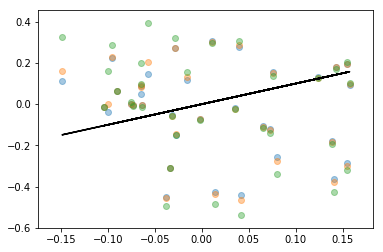

n_seq  18000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.95172296474653
eps 0.01 iterate 3001 1.4575340924464213
eps 0.01 iterate 6002 1.407537894279315
eps 0.01 iterate 9003 1.39070830095926
eps 0.01 iterate 12004 1.38320999631358
eps 0.01 iterate 15005 1.379602645019883
eps 0.01 iterate 18006 1.3779131821120039
eps 0.01 iterate 21007 1.3772521494363161
eps 0.01 iterate 24008 1.3771693474749567
eps 0.01 iterate 27009 1.3774160927471182
n_ops 34
eps 0.1 iterate 0 1.9492666818264845
eps 0.1 iterate 301 1.4761825385478218
eps 0.1 iterate 602 1.4323325556610143
eps 0.1 iterate 903 1.4202739896611714
eps 0.1 iterate 1204 1.4170469228577858
eps 0.1 iterate 1505 1.4174734076139326
eps 0.1 iterate 1806 1.4196900215149453
eps 0.1 iterate 2107 1.4228660223453748
eps 0.1 iterate 2408 1.426588351292176
eps 0.1 iterate 2709 1.4306355735906198
n_ops 34
eps 0.2 iterate 0 1.9469234232768884
eps 0.2 iterate 151 1.5073785838952147
eps 0.2 iterate 302 1.4777676584557609
eps 0.2 iterate 453 1.4808847679307502
ep

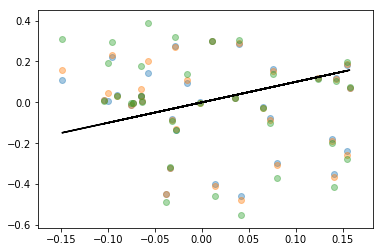

n_seq  33000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.951304155321546
eps 0.01 iterate 3001 1.459102121668651
eps 0.01 iterate 6002 1.4060220013110305
eps 0.01 iterate 9003 1.3871846131854182
eps 0.01 iterate 12004 1.37845844571286
eps 0.01 iterate 15005 1.3741103512384276
eps 0.01 iterate 18006 1.3719947536967947
eps 0.01 iterate 21007 1.3711118339336816
eps 0.01 iterate 24008 1.3709356629619909
eps 0.01 iterate 27009 1.3711653854566102
n_ops 34
eps 0.1 iterate 0 1.948897110418962
eps 0.1 iterate 301 1.4781677189644165
eps 0.1 iterate 602 1.4312178036874807
eps 0.1 iterate 903 1.4171230698122432
eps 0.1 iterate 1204 1.4126451699926292
eps 0.1 iterate 1505 1.4123021038564318
eps 0.1 iterate 1806 1.4140498732660187
eps 0.1 iterate 2107 1.4169425914013145
eps 0.1 iterate 2408 1.4204897700326897
eps 0.1 iterate 2709 1.4244186679769277
n_ops 34
eps 0.2 iterate 0 1.9466252597381903
eps 0.2 iterate 151 1.5100094486077063
eps 0.2 iterate 302 1.4771432151005532
eps 0.2 iterate 453 1.477989756932069

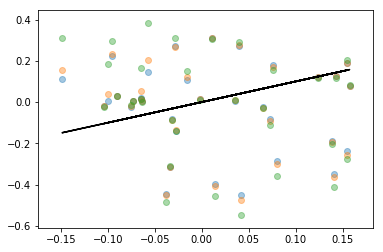

n_seq  48000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.9510397148336565
eps 0.01 iterate 3001 1.460336548670859
eps 0.01 iterate 6002 1.407555583010304
eps 0.01 iterate 9003 1.388918722259206
eps 0.01 iterate 12004 1.3803657971873031
eps 0.01 iterate 15005 1.3760872053383404
eps 0.01 iterate 18006 1.3739244459011735
eps 0.01 iterate 21007 1.3729049139302403
eps 0.01 iterate 24008 1.372539752046186
eps 0.01 iterate 27009 1.3725606825302334
n_ops 34
eps 0.1 iterate 0 1.9486251807928798
eps 0.1 iterate 301 1.479416718528485
eps 0.1 iterate 602 1.4328507280872975
eps 0.1 iterate 903 1.419045502308484
eps 0.1 iterate 1204 1.4148008863637183
eps 0.1 iterate 1505 1.414563149057231
eps 0.1 iterate 1806 1.4162864075431487
eps 0.1 iterate 2107 1.419060738328797
eps 0.1 iterate 2408 1.4224373248174087
eps 0.1 iterate 2709 1.4261770124543147
n_ops 34
eps 0.2 iterate 0 1.9463537674322984
eps 0.2 iterate 151 1.5113148277028379
eps 0.2 iterate 302 1.4789323320188568
eps 0.2 iterate 453 1.48016390875694
eps

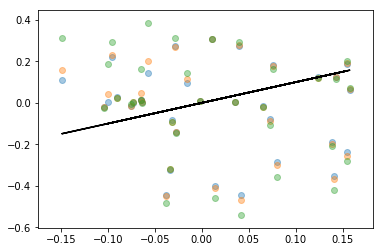

n_seq  63000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.9510734325019141
eps 0.01 iterate 3001 1.4591759671500855
eps 0.01 iterate 6002 1.4069136799256823
eps 0.01 iterate 9003 1.3886530912569106
eps 0.01 iterate 12004 1.3804026090535677
eps 0.01 iterate 15005 1.3764303220620107
eps 0.01 iterate 18006 1.37459415336162
eps 0.01 iterate 21007 1.373909180119291
eps 0.01 iterate 24008 1.3738678067713053
eps 0.01 iterate 27009 1.3741857824813994
n_ops 34
eps 0.1 iterate 0 1.9486245959398403
eps 0.1 iterate 301 1.4783006971462638
eps 0.1 iterate 602 1.4322729434850061
eps 0.1 iterate 903 1.4188342248241823
eps 0.1 iterate 1204 1.414895585107206
eps 0.1 iterate 1505 1.4149736043157006
eps 0.1 iterate 1806 1.4170290907552872
eps 0.1 iterate 2107 1.420135638161263
eps 0.1 iterate 2408 1.4238263305569498
eps 0.1 iterate 2709 1.4278495603127817
n_ops 34
eps 0.2 iterate 0 1.9463194107826347
eps 0.2 iterate 151 1.5102107405966345
eps 0.2 iterate 302 1.4784456743253458
eps 0.2 iterate 453 1.480122713412737

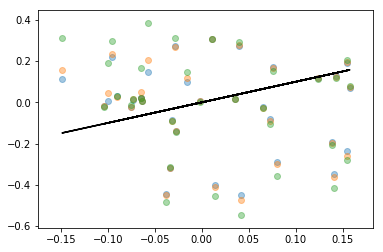

n_seq  78000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.951060644454568
eps 0.01 iterate 3001 1.4582529372199113
eps 0.01 iterate 6002 1.4058694491503076
eps 0.01 iterate 9003 1.3878438485160192
eps 0.01 iterate 12004 1.3799017660269302
eps 0.01 iterate 15005 1.37625196897132
eps 0.01 iterate 18006 1.3747282991709082
eps 0.01 iterate 21007 1.3743307914285818
eps 0.01 iterate 24008 1.374542236340486
eps 0.01 iterate 27009 1.3750732126659106
n_ops 34
eps 0.1 iterate 0 1.9485970615383363
eps 0.1 iterate 301 1.4774772091285955
eps 0.1 iterate 602 1.4313984968512656
eps 0.1 iterate 903 1.418199968680444
eps 0.1 iterate 1204 1.414555642761603
eps 0.1 iterate 1505 1.414927707962687
eps 0.1 iterate 1806 1.417252478102775
eps 0.1 iterate 2107 1.4205903333186904
eps 0.1 iterate 2408 1.4244685747539148
eps 0.1 iterate 2709 1.4286350620745156
n_ops 34
eps 0.2 iterate 0 1.946278972358387
eps 0.2 iterate 151 1.509460872454463
eps 0.2 iterate 302 1.4776423742838507
eps 0.2 iterate 453 1.4794915048474313
eps

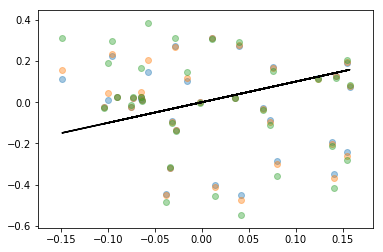

n_seq  93000
rbm2 
n_ops 34
eps 0.01 iterate 0 1.9511373589565533
eps 0.01 iterate 3001 1.4565993921554818
eps 0.01 iterate 6002 1.4046285892625667
eps 0.01 iterate 9003 1.3870559258979789
eps 0.01 iterate 12004 1.3794812031811061
eps 0.01 iterate 15005 1.3761183266168984
eps 0.01 iterate 18006 1.3748182673395322
eps 0.01 iterate 21007 1.3745970455306147
eps 0.01 iterate 24008 1.3749503256860969
eps 0.01 iterate 27009 1.3755981642664974
n_ops 34
eps 0.1 iterate 0 1.9486579909048378
eps 0.1 iterate 301 1.47587955313777
eps 0.1 iterate 602 1.4301595412782313
eps 0.1 iterate 903 1.4173632955617406
eps 0.1 iterate 1204 1.4140483468176994
eps 0.1 iterate 1505 1.4146805894723775
eps 0.1 iterate 1806 1.4172120115932048
eps 0.1 iterate 2107 1.4207176445365874
eps 0.1 iterate 2408 1.424736092500192
eps 0.1 iterate 2709 1.429022999315143
n_ops 34
eps 0.2 iterate 0 1.9463216736726259
eps 0.2 iterate 151 1.5078912418117891
eps 0.2 iterate 302 1.4763802804318369
eps 0.2 iterate 453 1.47860218966455

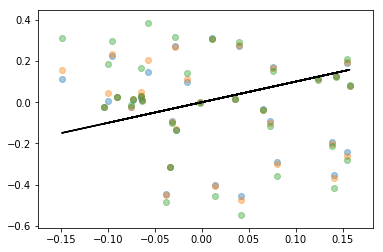

In [41]:
n_var,n_seq = 10,100000
np.random.seed(0)
RBM0=4

w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)
for n_part in range(3000,100001,15000):
    print('n_seq ',n_part)
    print('rbm2 ')
    for eps in [0.01,0.1,0.2]:
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
#        eps_machine_rbm(w_trial,seqs[:n_part],max_iter=int(50/eps),eps_scale=eps,cov=False,RBM=RBM0)

        eps_machine_rbm2(w_trial,seqs[:n_part],max_iter=int(300/eps),eps_scale=eps,cov=False,RBM=RBM0)

        plt.scatter(w_true,w_trial,alpha=0.4)
    plt.plot(w_true,w_true,'k')
    plt.show()
    plt.close()



In [13]:
def eps_machine_rbm3(w,s,eps_scale=.01,max_iter=50,alpha=0.1,cov=False,RBM=0):
    """trying to avoid summing over all states of the hidden variables"""
    n_seq,n_var = s.shape
    ops = operators(s,RBM=RBM)
    n_ops = ops.shape[1]
    print('n_ops',n_ops)
    if RBM>0:
        n_rbm_couplings = (1+n_var-RBM)*RBM
        s_temp = np.copy(s)
        w_iA = (w[-n_rbm_couplings+RBM:].reshape((n_var-RBM,RBM)))
        v_A = (w[n_var-RBM:n_var].reshape((RBM)))
        u_i = (w[:n_var-RBM].reshape((n_var-RBM)))
        s_temp[:,-RBM:] = np.sign(v_A + s_temp[:,:n_var-RBM].dot(w_iA))
    ops_cov0 = np.cov(ops,rowvar=False,bias=True)
    if cov:
        cov_inv = spinv(ops_cov0)
    else: 
        cov_inv = np.eye(n_ops)

    for iterate in range(max_iter):
        if RBM==0:
            obs_energies_w = energy_ops(ops,w)
            probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
            max_obs = np.max(probs_w)
            probs_w = np.exp(probs_w - max_obs)
            probs_w /= np.sum(probs_w)
            ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
            sec_order = np.tanh(w*eps_scale)
            w += alpha*cov_inv.dot((ops_expect_w - sec_order))

        elif RBM>0:
            col_changelist = np.random.choice(RBM,size=1,replace=False)
            for inde in range(1):
                col_change = n_var-RBM+col_changelist[inde]
                col_hidden = np.random.choice([1,-1],size=(n_seq,1),replace=True)
                expect = np.random.rand(n_seq)<1.0/(np.exp((col_hidden[:,0]-s_temp[:,col_change])*\
                                                           (s_temp[:,:-RBM].dot(w_iA))[:,col_changelist[inde]])+1.0)
                s_temp[expect,col_change] = col_hidden[expect,0]
            ops_temp = operators(s_temp,RBM=RBM)
            obs_energies_w = energy_ops(ops_temp,w)
            probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
            max_obs = np.max(probs_w)
            probs_w = np.exp(probs_w - max_obs)
            probs_w /= np.sum(probs_w)
            ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops_temp,axis=0) #observed expectations
            sec_order = np.tanh(w*eps_scale)
            w += alpha*cov_inv.dot((ops_expect_w - sec_order))
            w_iA = (w[-n_rbm_couplings+RBM:].reshape((n_var-RBM,RBM)))
            v_A = (w[n_var-RBM:n_var].reshape((RBM)))
            u_i = (w[:n_var-RBM].reshape((n_var-RBM)))

        if iterate%(int(max_iter/10)+1)==0: 
            print('eps',eps_scale,'iterate',iterate,nplin.norm(w-w_true))
            #print(w-w_true)

n_seq  3000
rbm3 
n_ops 34
eps 0.01 iterate 0 2.0224941019085714
eps 0.01 iterate 301 0.45307835991406903
eps 0.01 iterate 602 0.44403543576077764
eps 0.01 iterate 903 0.44096008030323036
eps 0.01 iterate 1204 0.44073085265232503
eps 0.01 iterate 1505 0.4472967935228897
eps 0.01 iterate 1806 0.435555186355214
eps 0.01 iterate 2107 0.43765809138241213
eps 0.01 iterate 2408 0.44251786701674767
eps 0.01 iterate 2709 0.4340028251699788
n_ops 34
eps 0.1 iterate 0 2.0125968921793214
eps 0.1 iterate 31 0.4471426535409069
eps 0.1 iterate 62 0.43628095482875195
eps 0.1 iterate 93 0.45128812042636923
eps 0.1 iterate 124 0.4335378735108255
eps 0.1 iterate 155 0.4339607417576802
eps 0.1 iterate 186 0.4294692718086389
eps 0.1 iterate 217 0.42724686264494083
eps 0.1 iterate 248 0.45476283759401914
eps 0.1 iterate 279 0.4365777866861614
n_ops 34
eps 0.2 iterate 0 2.002152978793032
eps 0.2 iterate 16 0.7618233550221362
eps 0.2 iterate 32 0.4470014696479219
eps 0.2 iterate 48 0.45447738360838075
eps 0.

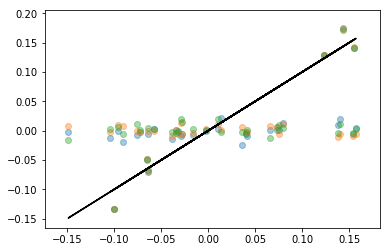

n_seq  18000
rbm3 
n_ops 34
eps 0.01 iterate 0 2.0191804881108943
eps 0.01 iterate 301 0.4380185343398324
eps 0.01 iterate 602 0.44014491504203046
eps 0.01 iterate 903 0.44064903285970003
eps 0.01 iterate 1204 0.44005205357728844
eps 0.01 iterate 1505 0.42759695196572045
eps 0.01 iterate 1806 0.43554569009517835
eps 0.01 iterate 2107 0.4386108571588432
eps 0.01 iterate 2408 0.43557933975618585
eps 0.01 iterate 2709 0.43862921275730415
n_ops 34
eps 0.1 iterate 0 2.0091346369197893
eps 0.1 iterate 31 0.4462290161363766
eps 0.1 iterate 62 0.44350593924780674
eps 0.1 iterate 93 0.4336721754103659
eps 0.1 iterate 124 0.42814251317769086
eps 0.1 iterate 155 0.42907335648420547
eps 0.1 iterate 186 0.4261268585640096
eps 0.1 iterate 217 0.4314197602863181
eps 0.1 iterate 248 0.4409649928583868
eps 0.1 iterate 279 0.4373881299685443
n_ops 34
eps 0.2 iterate 0 1.9986296124755272
eps 0.2 iterate 16 0.8575669199501862
eps 0.2 iterate 32 0.4419701779812859
eps 0.2 iterate 48 0.4372616869256414
eps 

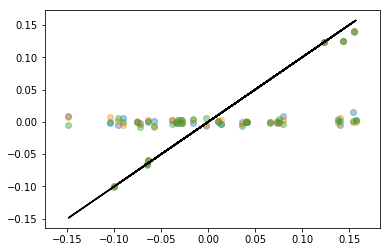

n_seq  33000
rbm3 
n_ops 34
eps 0.01 iterate 0 2.0188282601869276
eps 0.01 iterate 301 0.437044641940938
eps 0.01 iterate 602 0.4330231284288519
eps 0.01 iterate 903 0.4357045397825895
eps 0.01 iterate 1204 0.43298623625781796
eps 0.01 iterate 1505 0.43278407601301555
eps 0.01 iterate 1806 0.43540952201062205
eps 0.01 iterate 2107 0.43626348653226604
eps 0.01 iterate 2408 0.4393902260998427
eps 0.01 iterate 2709 0.4317047919156433


KeyboardInterrupt: 

In [14]:
n_var,n_seq = 10,100000
np.random.seed(0)
RBM0=4

w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)
for n_part in range(3000,100001,15000):
    print('n_seq ',n_part)
    print('rbm3 ')
    for eps in [0.01,0.1,0.2]:
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
#        eps_machine_rbm(w_trial,seqs[:n_part],max_iter=int(50/eps),eps_scale=eps,cov=False,RBM=RBM0)

        eps_machine_rbm3(w_trial,seqs[:n_part],max_iter=int(30/eps),eps_scale=eps,cov=False,RBM=RBM0)

        plt.scatter(w_true,w_trial,alpha=0.4)
    plt.plot(w_true,w_true,'k')
    plt.show()
    plt.close()



In [22]:
def eps_machine_step(n_seq,w,ops,eps_scale,alpha):
    obs_energies_w = energy_ops(ops,w)
    sec_order = np.tanh(w*eps_scale)
    probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
    max_obs = np.max(probs_w)
    probs_w = np.exp(probs_w - max_obs)
    probs_w /= np.sum(probs_w)
    ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
    return alpha*(ops_expect_w - sec_order)

def log_prob_given(s,col,w):
    s_temp = np.copy(s)
    s_temp[:,col] = -s_temp[:,col]
    return np.log(1.0/(1.0 + np.exp(energy_ops(operators(s_temp),w)-energy_ops(operators(s),w))))

def tau_update(n_seq,n_var,RBM,ops,w):
    sigma_i = ops[:,:n_var-RBM]
    if RBM>0:
        tau_A =  ops[:,n_var-RBM:n_var]
        w_iA = (w[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
        v_A = (w[n_var-RBM:n_var].reshape((RBM)))
        u_i = (w[:n_var-RBM].reshape((n_var-RBM)))
        combo = u_i[np.newaxis,:] + w_iA.dot(tau_A.T).T
        #     prob_sigma_before = np.mean(np.sum(sigma_i*combo-np.log(2*np.cosh(combo)),axis=1),axis=0)
        rand = np.random.rand(n_seq,RBM)
        alt_tau = np.random.choice([1,-1],size=(n_seq,RBM))
        combo_tau = v_A[np.newaxis,:] + sigma_i.dot(w_iA)
        prob_tau = (tau_A-alt_tau)*combo_tau #-np.log(2*np.cosh(combo_tau))
        tau_temp = 1.0/(1.0+np.exp(prob_tau))
        rand_choice = tau_temp >= rand # present tau_A[index] is less likely
        s_temp = np.copy(ops[:,:n_var])
        s_temp[:,n_var-RBM:n_var][rand_choice] = (alt_tau[rand_choice])
        combo = u_i[np.newaxis,:] + w_iA.dot(s_temp[:,n_var-RBM:n_var].T).T
        prob_sigma_orig = np.mean(np.sum(sigma_i*combo-np.log(2*np.cosh(combo)),axis=1),axis=0)
        rand = np.random.rand(n_seq,n_var-RBM)
        alt_sigma = np.random.choice([1,-1],size=(n_seq,n_var-RBM))
        prob_sigma = (sigma_i-alt_sigma)*combo #-np.log(2*np.cosh(combo))
        sigma_temp = 1.0/(1.0+np.exp(prob_sigma))
        rand_choice = sigma_temp >= rand # present sigma[index] is less likely
        s_temp1 = np.copy(s_temp[:,:n_var])
        s_temp1[:,:n_var-RBM][rand_choice] = (alt_sigma[rand_choice])
        combo1 = u_i[np.newaxis,:] + w_iA.dot(s_temp1[:,n_var-RBM:n_var].T).T
        prob_sigma_fake = np.mean(np.sum(s_temp1[:,:n_var-RBM]*combo1-np.log(2*np.cosh(combo1)),axis=1),axis=0)
        ops_new = operators(s_temp1,RBM=RBM)
    else:
#         w_iA = np.zeros(n_var,n_var)
#         u_i = w[:n_var]
#         j_index = n_var
#         for index in range(n_var-1):
#             for index1 in range(index+1,n_var):
#                 w_iA[index,index1] = w[jindex]
#                 jindex +=1
#         w_iA += w_iA.T #symmetric
        energy_orig = energy_ops(ops,w)
        prob_sigma_fake = 0.0
        prob_sigma_orig = 0.0
        s_temp1,s_new = np.copy(ops[:,:n_var]),np.copy(ops[:,:n_var])
        for col in range(n_var):
            rand = np.random.rand(n_seq)
            s_temp = np.copy(ops[:,:n_var])
            s_temp[:,col] = np.random.choice([1,-1],size=(n_seq))
            prob_flip = 1.0/(1.0+np.exp(energy_orig - energy_ops(operators(s_temp,RBM=0),w)))
            rand_choice = prob_flip >= rand # present sigma[col] is less likely
            s_temp1[rand_choice,col] = s_temp[rand_choice,col]
            s_new[rand_choice,col] = s_temp[rand_choice,col]
            prob_sigma_fake += np.mean(log_prob_given(s_temp1,col,w))
            s_temp1 = np.copy(ops[:,:n_var])
            prob_sigma_orig += np.mean(log_prob_given(s_temp1,col,w))
        ops_new = operators(s_new)
    return operators(s_temp,RBM=RBM),ops_new,prob_sigma_orig-prob_sigma_fake

#s is spins including random configs of hidden spins
def eps_machine_rbm_EM(w_true,w,s,eps_scale=.01,max_iter=50,alpha=0.05,RBM=0,W_rep=30):
    n_seq,n_var = s.shape
    s_temp = np.copy(s)
    s_temp[:,n_var-RBM:n_var] = np.random.choice([1,-1],size=(n_seq,RBM))
    
    ops = operators(s_temp,RBM=RBM)
    ops_flip = np.copy(ops)
    prob_sig,eigs_list = [],[]
    for iterate in range(max_iter):
        w_new = np.copy(w)
#         w_new += eps_machine_step(n_seq,w,ops,eps_scale,alpha)
#        if iterate>W_rep: w_new -= (iterate/float(max_iter))*eps_machine_step(n_seq,w,ops_flip,eps_scale,alpha)
        
        for w_rep in range(int(W_rep)): #more w updates before trying to update the hidden spins
            delta_w_new = eps_machine_step(n_seq,w_new,ops,eps_scale,alpha)
            if w_rep == 0:
                if iterate > 0: 
                    size_dw_init_prev,size_dw_final_prev = size_dw_init,size_dw
                size_dw_init = nplin.norm(delta_w_new)
            size_dw = nplin.norm(delta_w_new)
            w_new += delta_w_new
#             print(iterate,'w_rep',w_rep,size_dw)
            if size_dw/size_dw_init < 0.5: break
#         eps_scale = 0.5*min(1.0,1.0/np.max(np.abs(w)))
#         print('eps',eps_scale)
        w = np.copy(w_new)
        ops,ops_flip,prob_sigma_orig_fake = tau_update(n_seq,n_var,RBM,ops,w)
        prob_sig.append(prob_sigma_orig_fake)
        
        #            print(iterate,prob_sigma_bef,prob_sigma)
        if 1==1:#iterate%(int(max_iter/5))==0:
            if RBM>0:
                w_iA = (w[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
                w_ij = w_iA.dot(w_iA.T)
                eigs,u = nplin.eigh(w_ij)
                wtrue_iA = (w_true[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
                wtrue_ij = wtrue_iA.dot(wtrue_iA.T)
                eigs_true,u = nplin.eigh(wtrue_ij)
                #                 print('eps',eps_scale,'iterate',iterate,nplin.norm(eigs-eigs_true))
                eigs_list.append(nplin.norm(eigs-eigs_true))
                plt.scatter(eigs_true,eigs,alpha=0.4)
                if iterate==0: plt.plot(eigs_true,eigs_true,'k-')
            else:
                #                 print('eps',eps_scale,'iterate',iterate,nplin.norm(w-w_true))
                plt.scatter(w_true,w,alpha=0.4)
    
        if iterate > 0:
            if np.sqrt((size_dw-size_dw_final_prev)**2 + (size_dw_init-size_dw_init_prev)**2) < 0.01*size_dw: 
                print('ending w_rep',w_rep,'iterate',iterate)
                break
        for ww_rep in range(max(1,int(w_rep/np.sqrt(float(iterate+1))))): #notice how many iterations we're doing!!
            delta_w_flip = eps_machine_step(n_seq,w_new,ops_flip,eps_scale,alpha)
            w_new -= delta_w_flip
        w = w_new
    plt.show()
    plt.close()
    plt.plot(np.arange(iterate+1),prob_sig,'ro')
    plt.show()
    plt.close()
    if RBM>0:
#         s[:,-RBM:] = ops[:,n_var-RBM:n_var] #this is mixing up the simulated order of the hidden spins!!!
        # so need to order correctly to make correct predictions of hidden spins

        
        plt.plot(np.arange(iterate+1),eigs_list,'ko')
        plt.show()
        plt.close()






In [12]:
n_var,n_seq = 20,20000
np.random.seed(0)
RBM0=10
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)


n_seq  5000
eps  0.75
ending w_rep 14 iterate 35


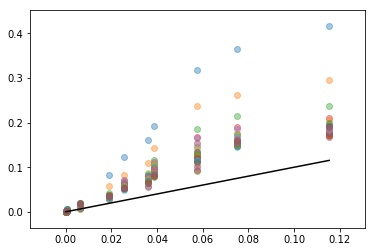

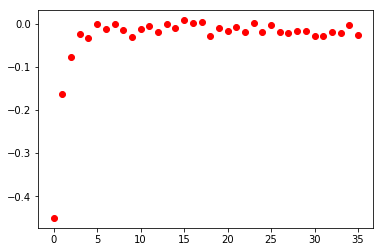

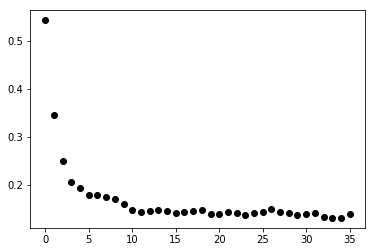

n_seq  10000
eps  0.75
ending w_rep 14 iterate 20


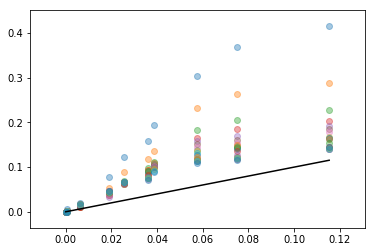

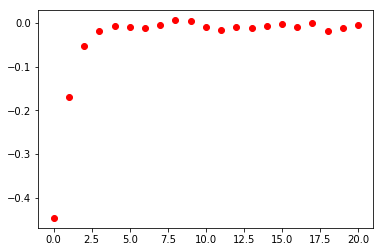

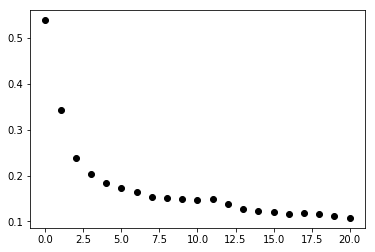

n_seq  15000
eps  0.75
ending w_rep 14 iterate 29


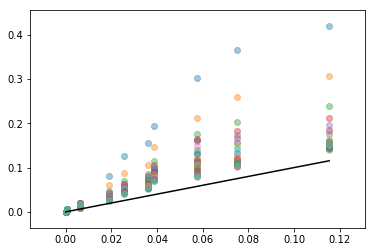

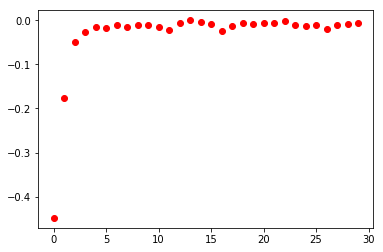

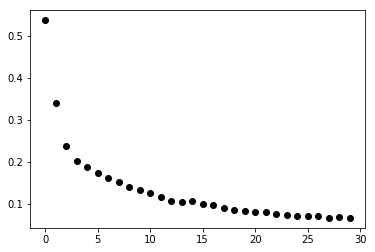

n_seq  20000
eps  0.75


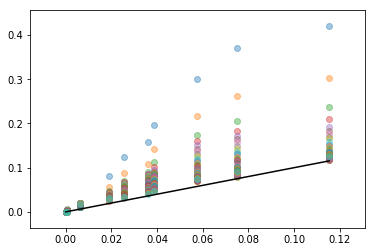

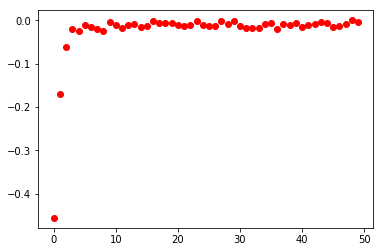

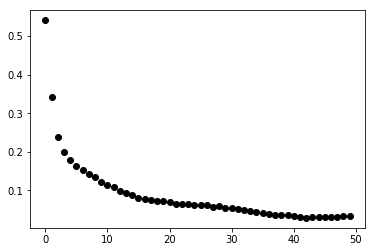

In [18]:
for n_part in range(5000,20001,5000):
    print('n_seq ',n_part)
    for eps in [.75]:#np.arange(3000./float(n_part),9001./float(n_part),3000./float(n_part)):#,0.1,0.2]:
        print('eps ',eps)
        np.random.seed(9)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) #-0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0) - 0.5
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=50,eps_scale=eps,RBM=RBM0)

In [25]:
n_var,n_seq = 10,10000
np.random.seed(0)
RBM0=0
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)



n_seq  1000
eps  0.5


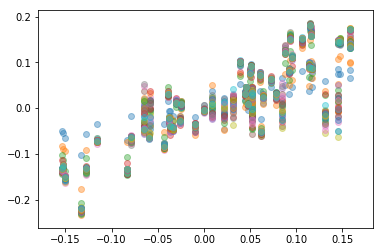

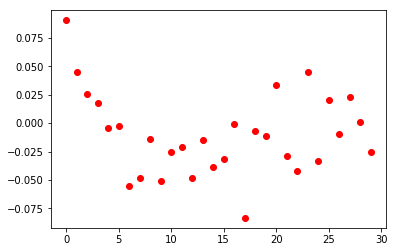

eps  0.75
ending w_rep 13 iterate 17


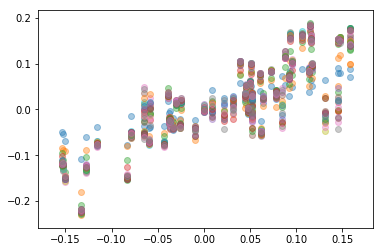

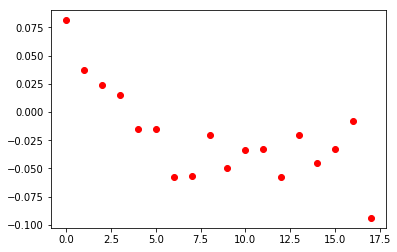

n_seq  21000
eps  0.5


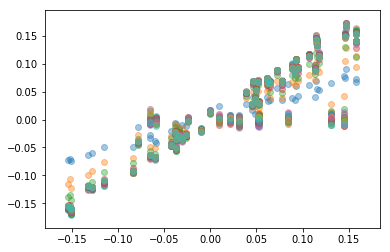

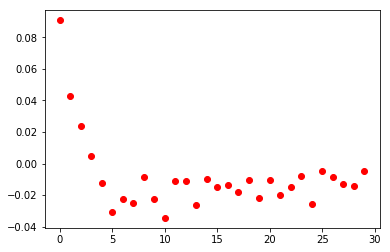

eps  0.75
ending w_rep 15 iterate 6


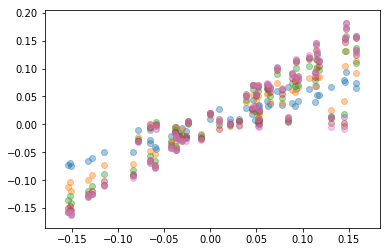

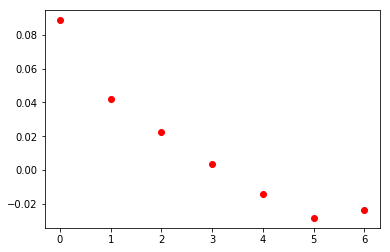

n_seq  41000
eps  0.5


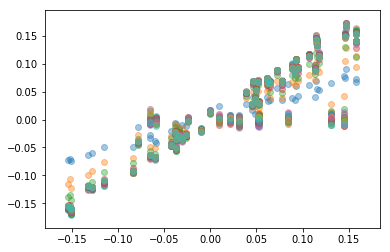

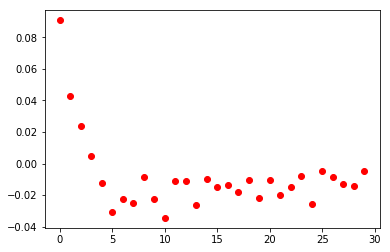

eps  0.75
ending w_rep 15 iterate 6


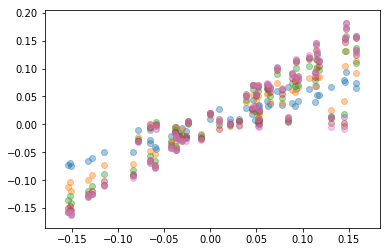

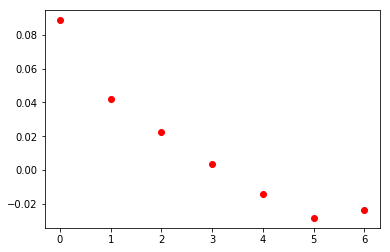

In [26]:
for n_part in range(1000,60001,20000):
    print('n_seq ',n_part)
    for eps in [0.5,0.75]: #np.arange(300./float(n_part),901./float(n_part),300./float(n_part)):#,0.1,0.2]:
        print('eps ',eps)
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) #-0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0) - 0.5
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=30,eps_scale=eps,RBM=RBM0)

In [87]:
n_var,n_seq = 30,60000
np.random.seed(0)
RBM0=15
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)



n_seq  2000
eps  0.5


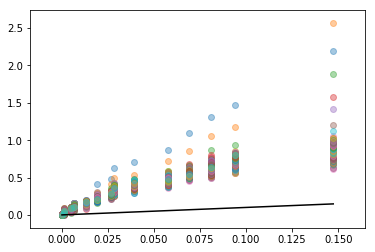

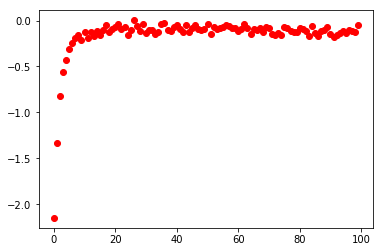

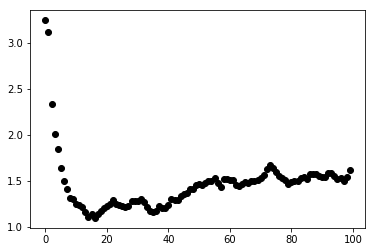

eps  0.75
ending w_rep 14 iterate 55


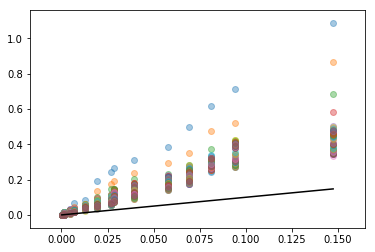

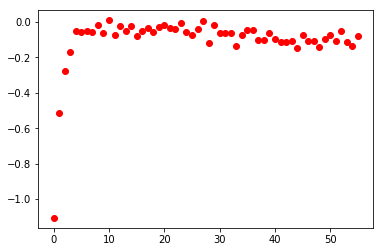

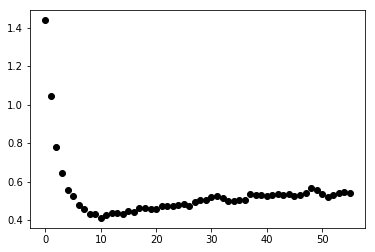

eps  1.0
ending w_rep 14 iterate 37


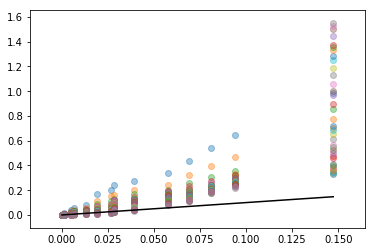

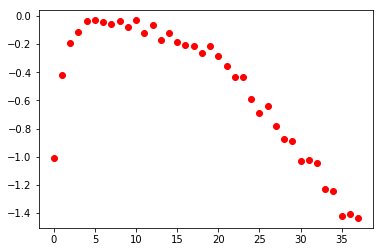

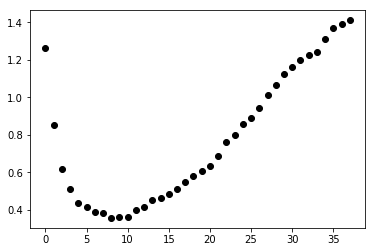

n_seq  12000
eps  0.5
ending w_rep 14 iterate 56


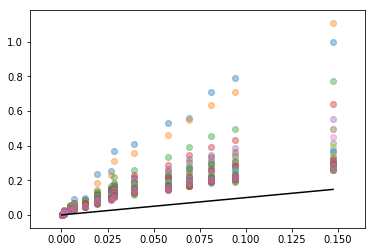

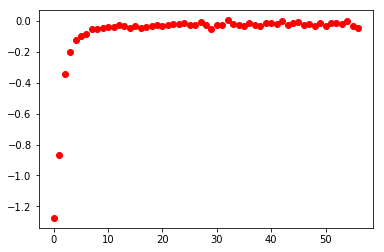

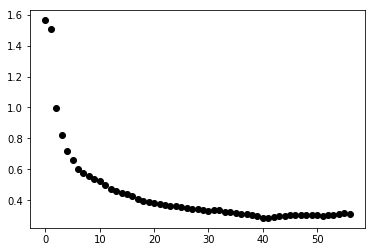

eps  0.75
ending w_rep 14 iterate 57


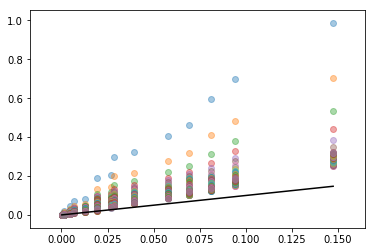

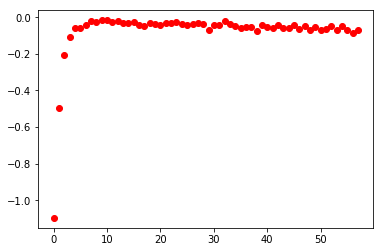

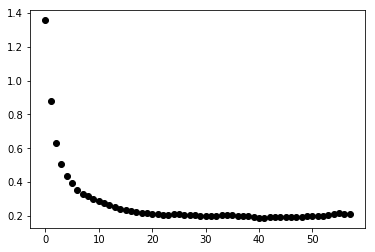

eps  1.0
ending w_rep 14 iterate 13


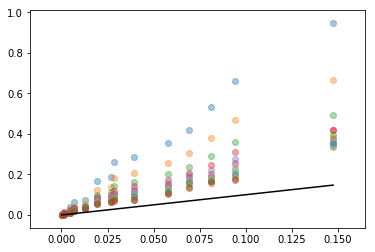

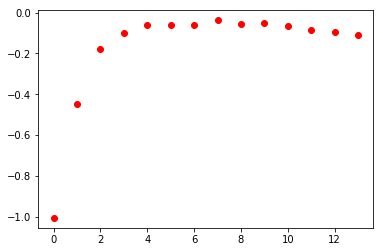

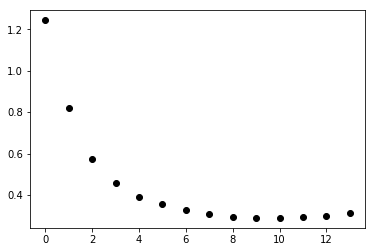

n_seq  22000
eps  0.5
ending w_rep 14 iterate 16


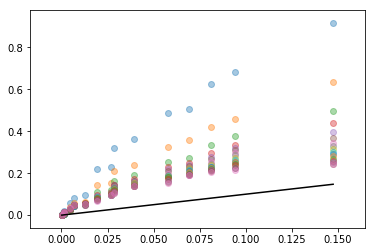

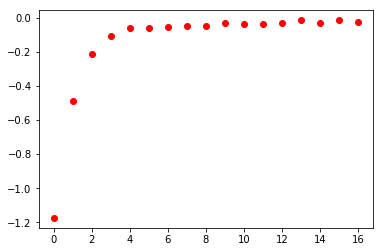

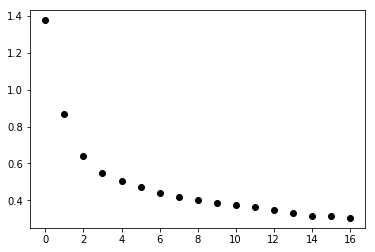

eps  0.75
ending w_rep 14 iterate 16


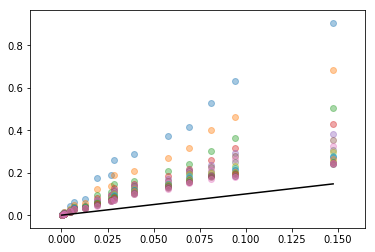

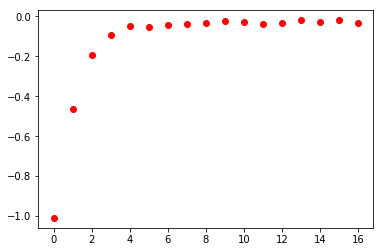

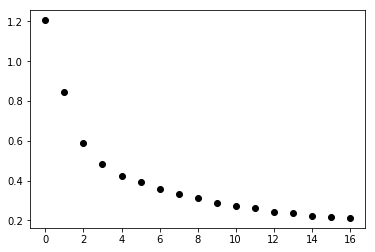

eps  1.0
ending w_rep 14 iterate 16


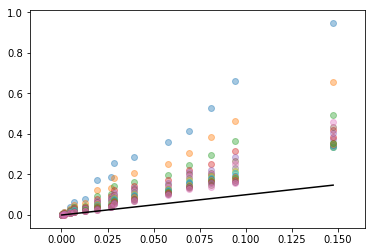

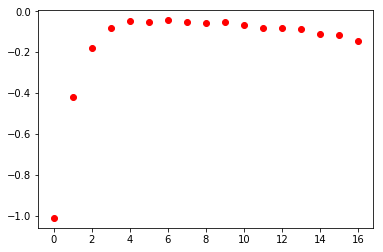

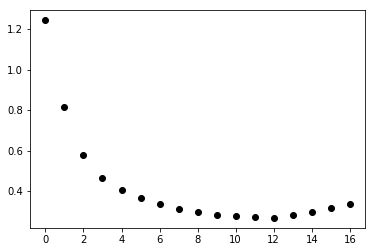

n_seq  32000
eps  0.5
ending w_rep 14 iterate 16


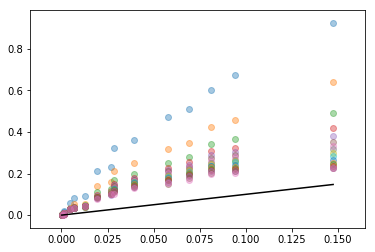

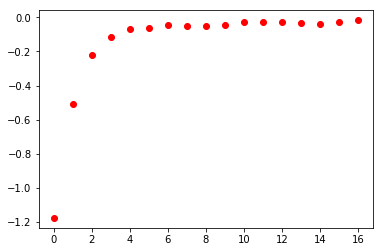

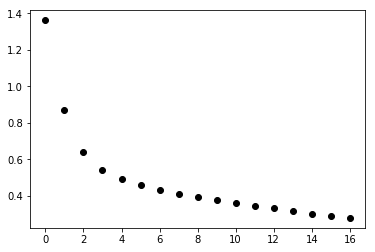

eps  0.75
ending w_rep 14 iterate 89


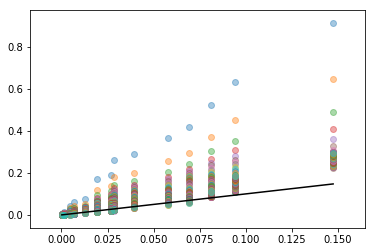

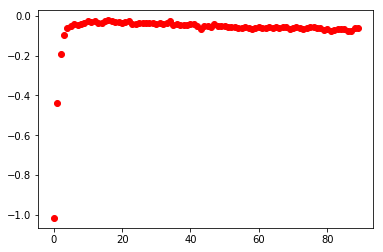

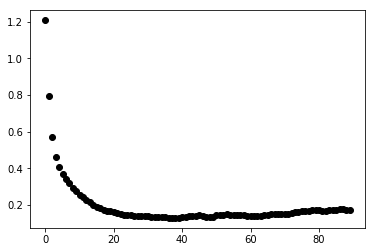

eps  1.0
ending w_rep 14 iterate 46


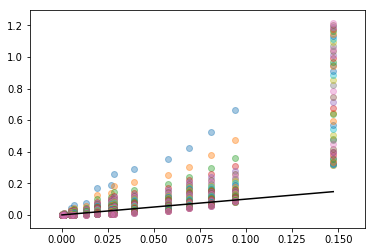

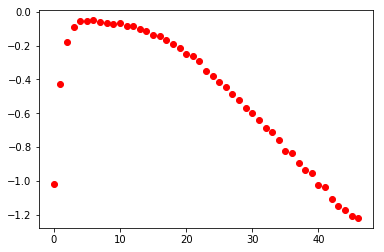

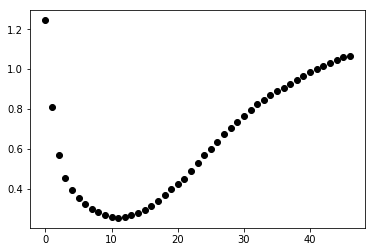

n_seq  42000
eps  0.5
ending w_rep 14 iterate 29


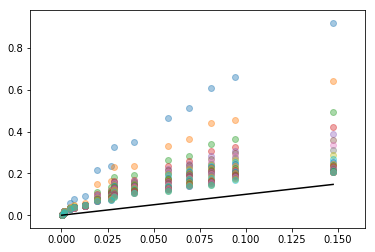

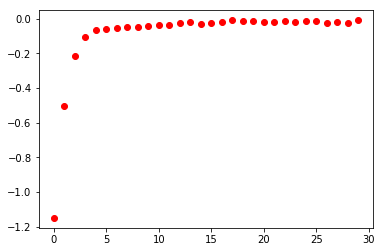

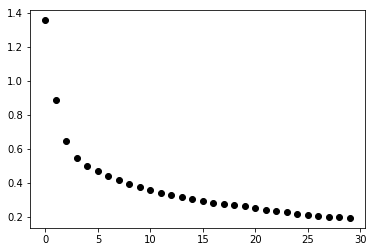

eps  0.75
ending w_rep 14 iterate 51


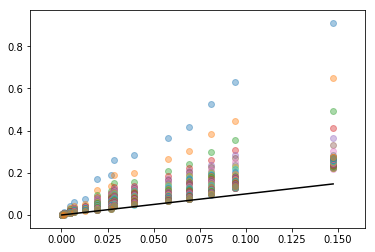

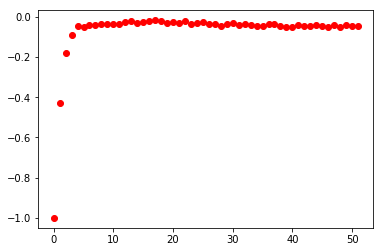

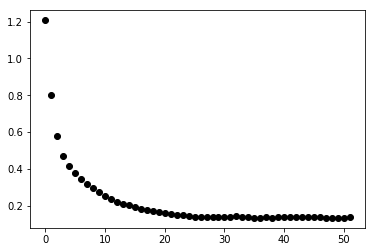

eps  1.0
ending w_rep 14 iterate 10


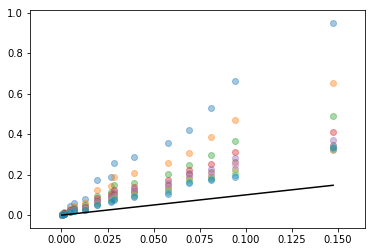

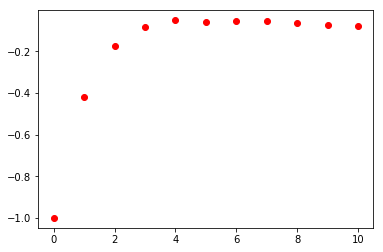

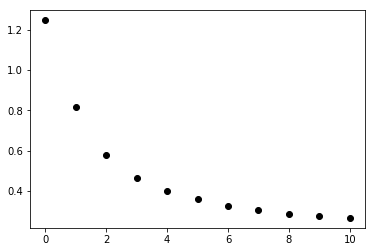

n_seq  52000
eps  0.5
ending w_rep 14 iterate 33


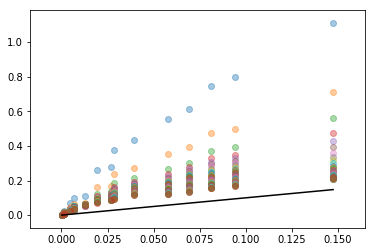

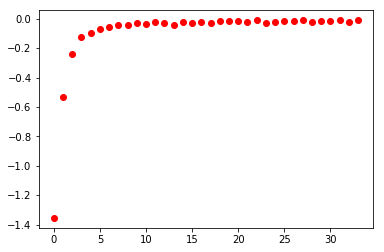

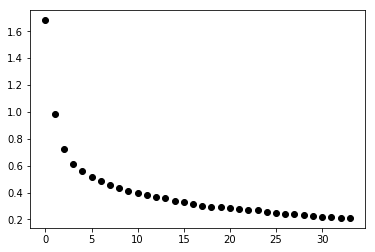

eps  0.75
ending w_rep 14 iterate 51


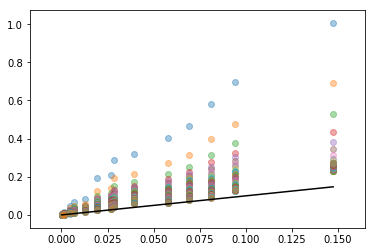

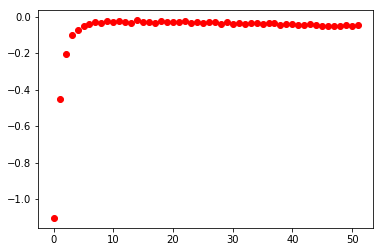

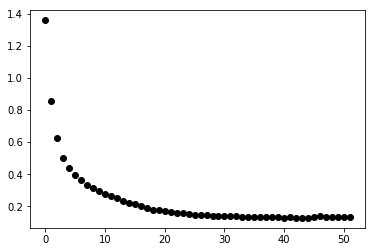

eps  1.0
ending w_rep 14 iterate 13


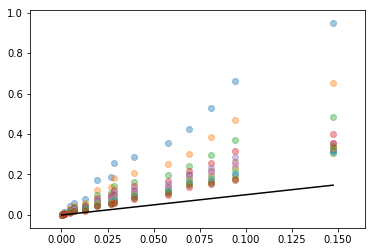

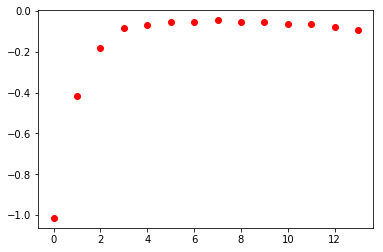

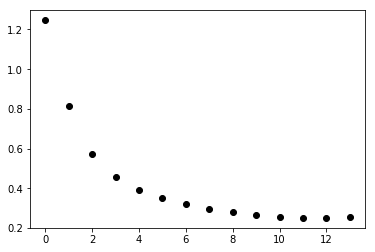

In [92]:
for n_part in range(2000,60001,10000):
    print('n_seq ',n_part)
    for eps in [0.5,0.75,1.]: #np.arange(300./float(n_part),901./float(n_part),300./float(n_part)):#,0.1,0.2]:
        print('eps ',eps)
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) #-0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0) - 0.5
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=100,eps_scale=eps,RBM=RBM0,W_rep=50)

n_seq  25000
rbm_EM 
ending 2


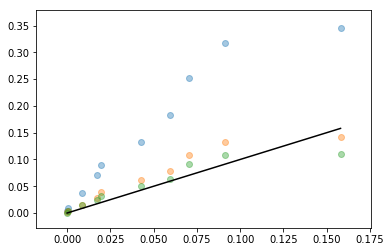

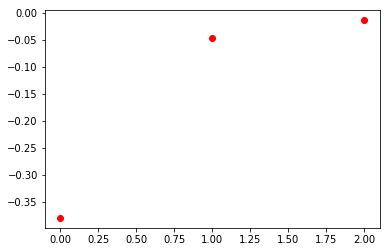

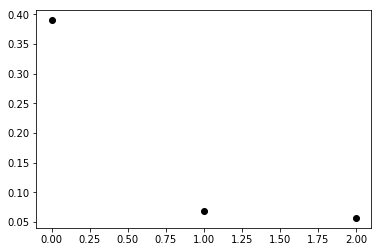

ending 2


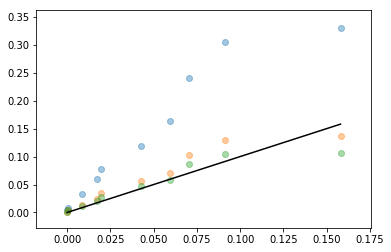

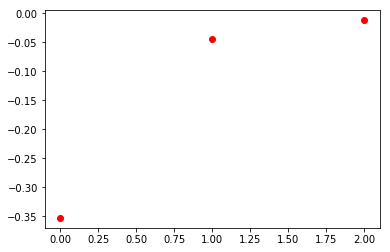

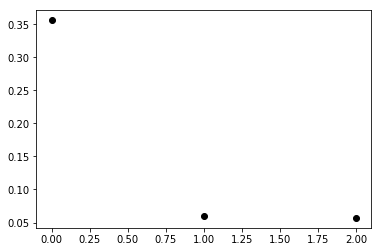

ending 2


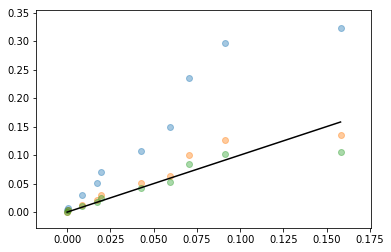

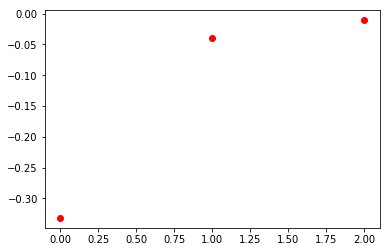

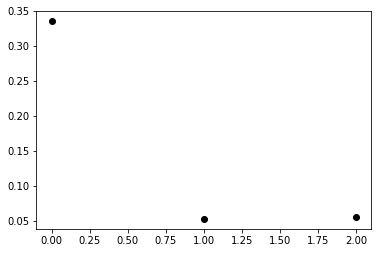

ending 2


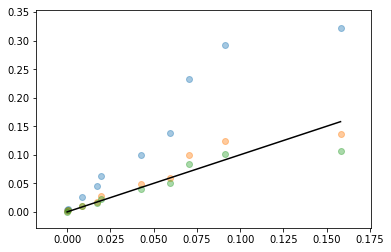

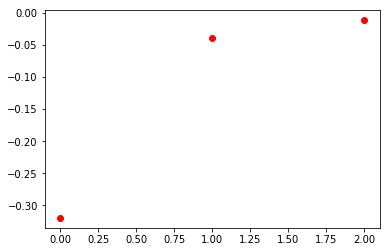

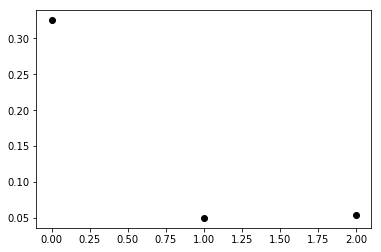

n_seq  36000
rbm_EM 
ending 2


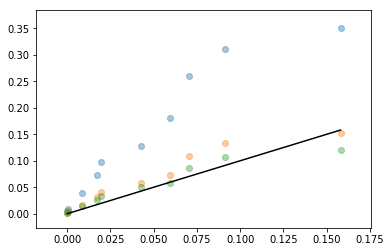

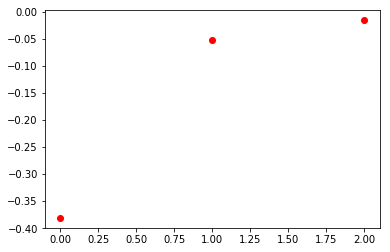

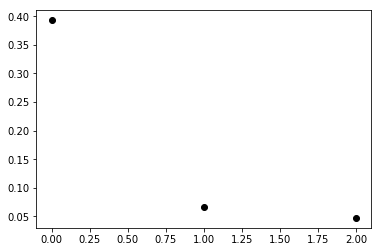

ending 2


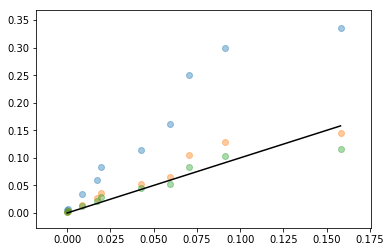

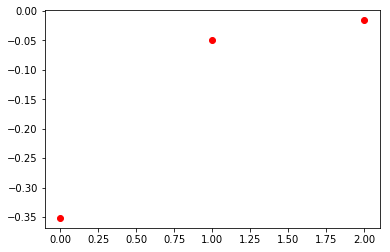

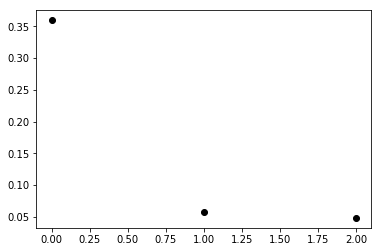

ending 2


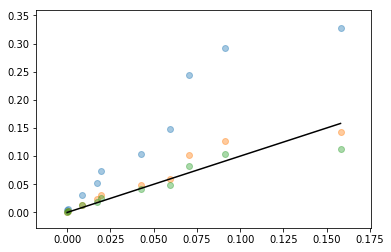

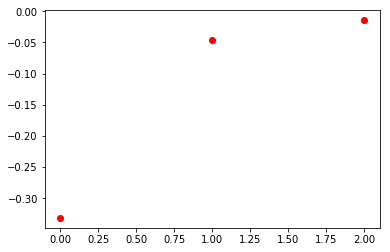

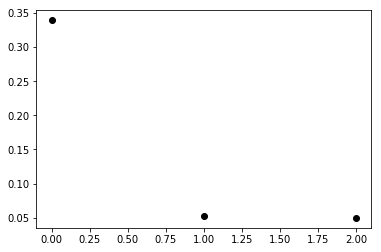

ending 2


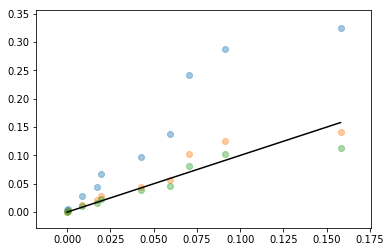

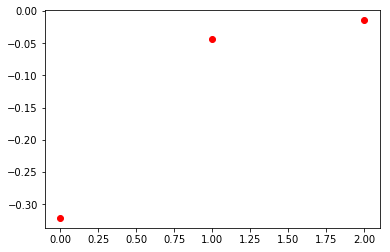

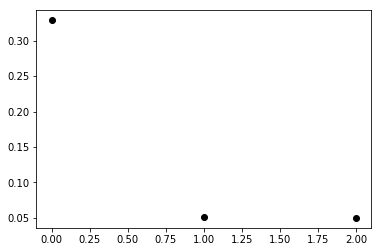

n_seq  47000
rbm_EM 
ending 2


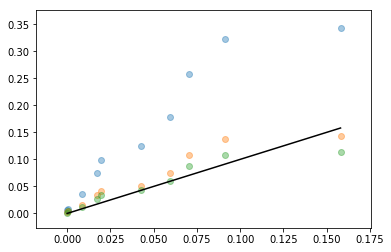

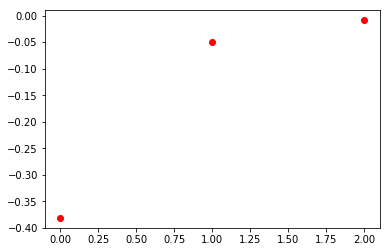

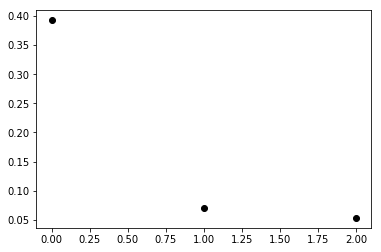

ending 2


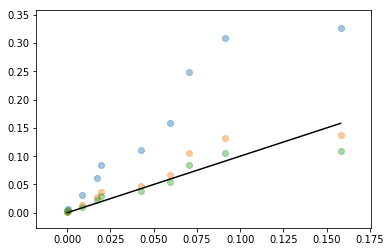

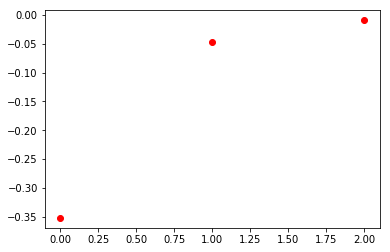

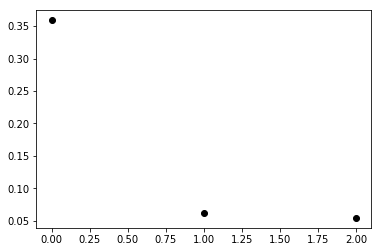

ending 2


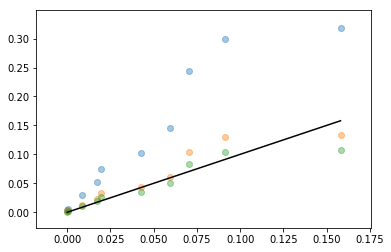

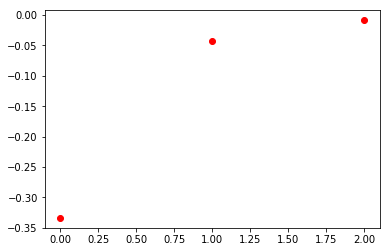

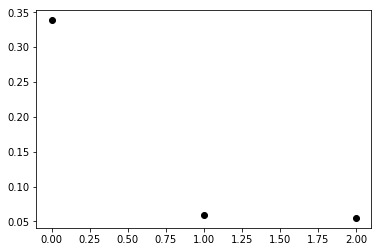

ending 2


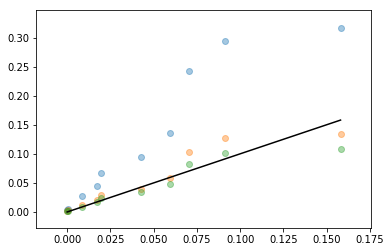

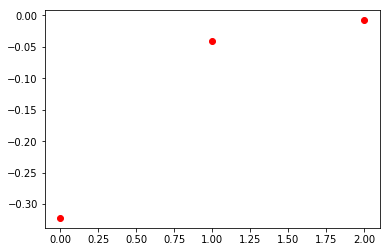

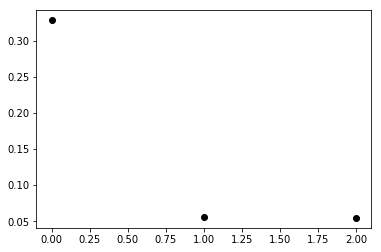

n_seq  58000
rbm_EM 
ending 2


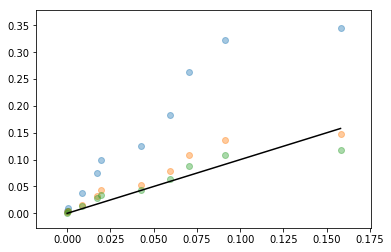

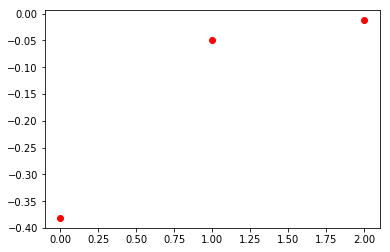

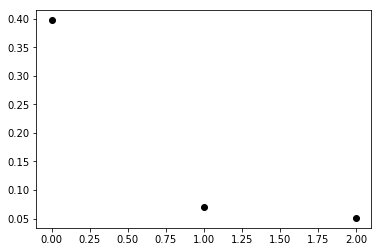

ending 2


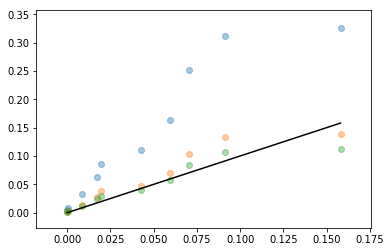

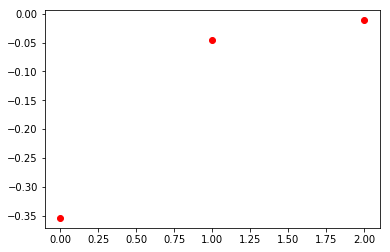

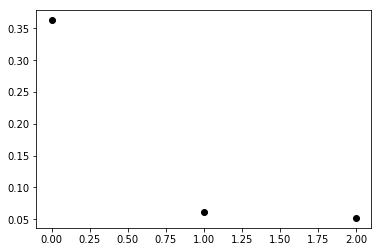

ending 2


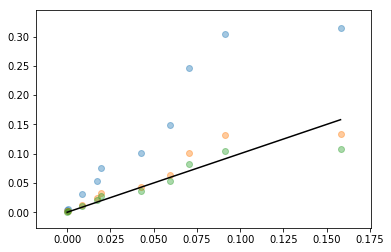

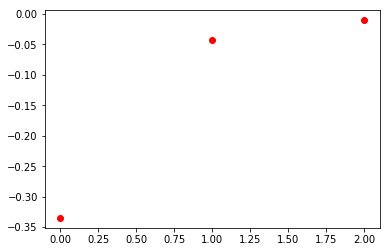

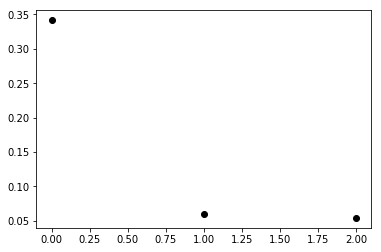

ending 2


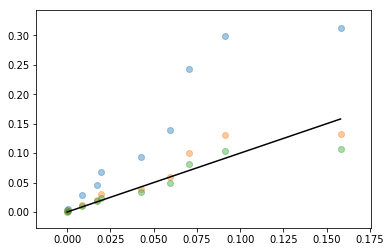

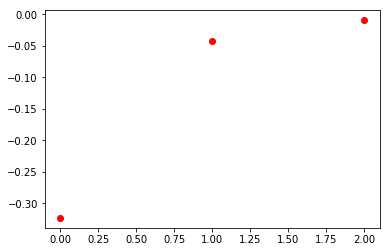

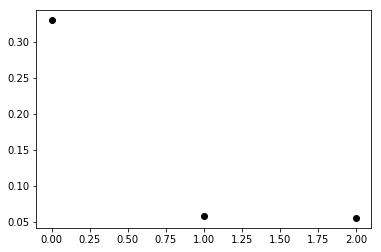

In [44]:
n_var,n_seq = 20,60000
np.random.seed(0)
RBM0=10
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)
for n_part in range(25000,60001,11000):
    print('n_seq ',n_part)
    print('rbm_EM ')
    for eps in [0.1,0.2,0.3,0.4]:
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=int(10/eps),eps_scale=eps,RBM=RBM0)


In [45]:
n_var,n_seq = 40,80000
np.random.seed(0)
RBM0=20
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)




n_seq  10000
eps 0.4


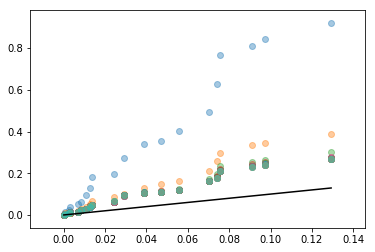

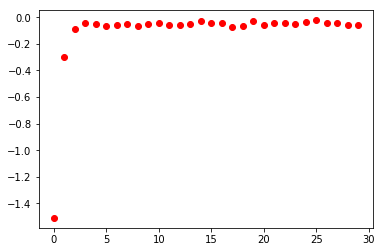

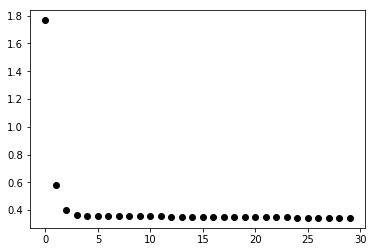

eps 0.8
ending 14


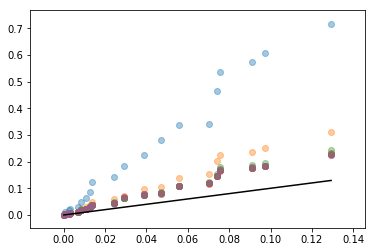

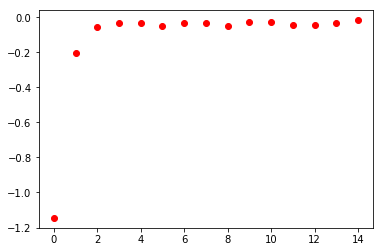

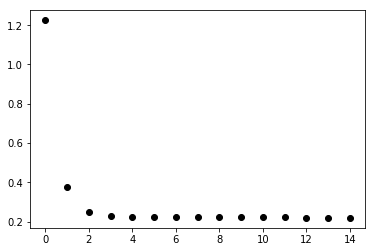

eps 1.2


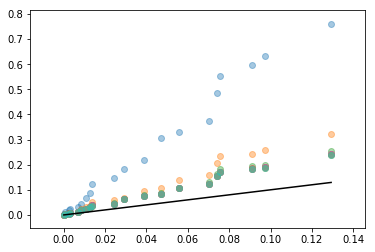

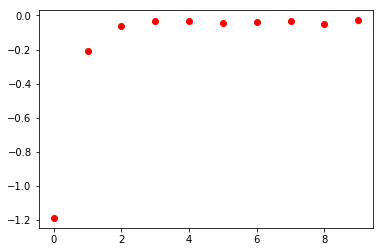

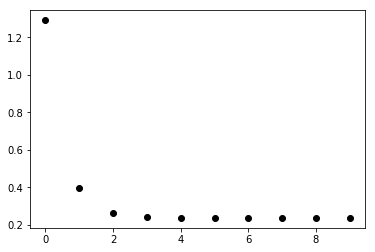

n_seq  40000
eps 0.4
ending 7


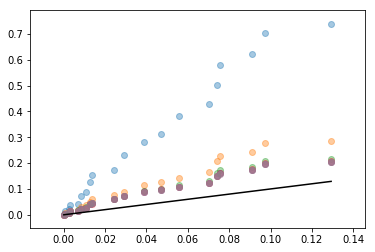

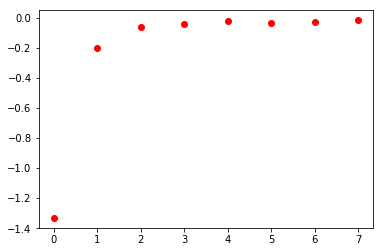

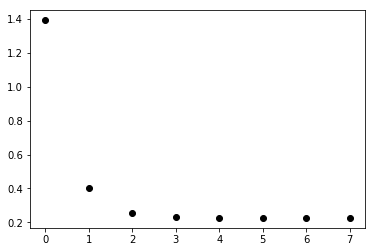

eps 0.8
ending 7


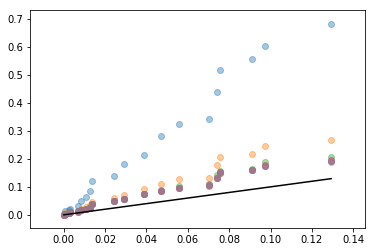

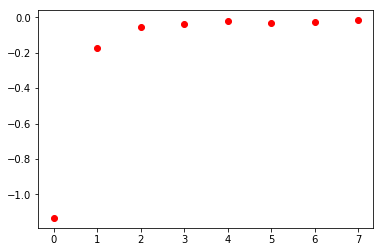

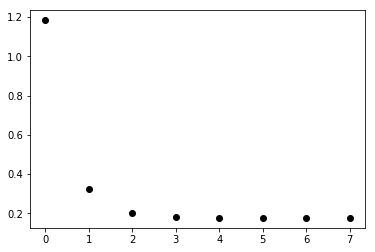

eps 1.2
ending 7


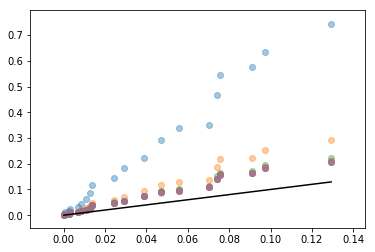

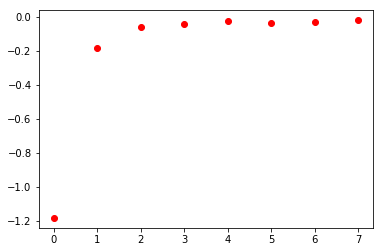

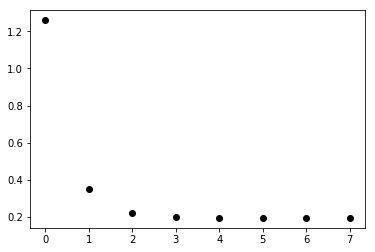

n_seq  70000
eps 0.4


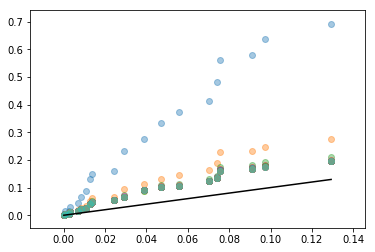

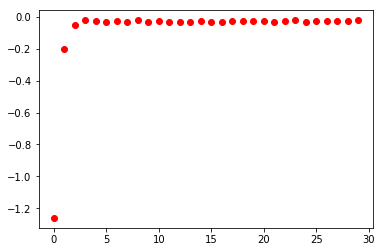

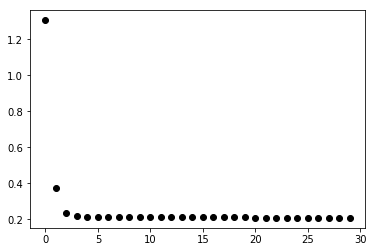

eps 0.8


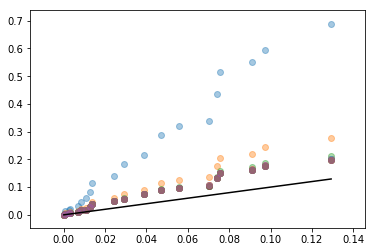

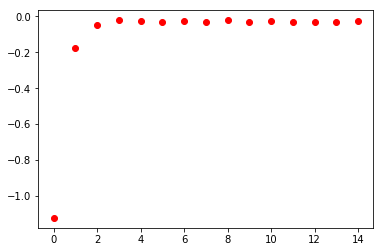

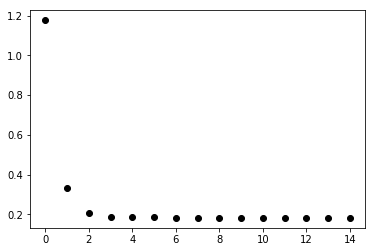

eps 1.2


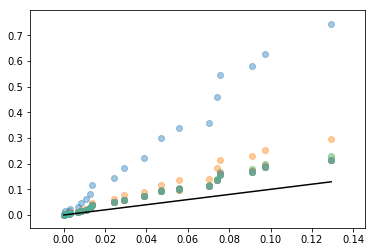

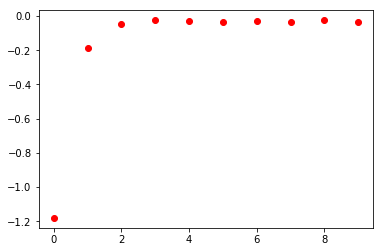

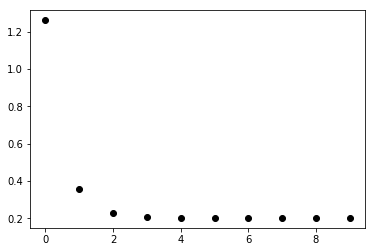

In [47]:
for n_part in range(10000,80001,30000):
    print('n_seq ',n_part)
    for eps in [0.4,0.8,1.2]:
        print('eps',eps)
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=int(12/eps),eps_scale=eps,RBM=RBM0)



In [48]:
n_var,n_seq = 80,80000
np.random.seed(0)
RBM0=20
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)


n_seq  10000
eps 0.4


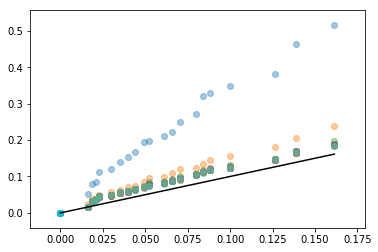

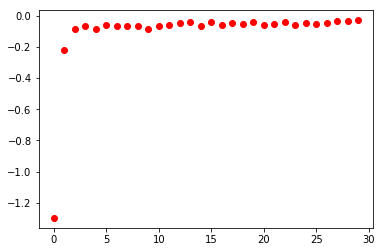

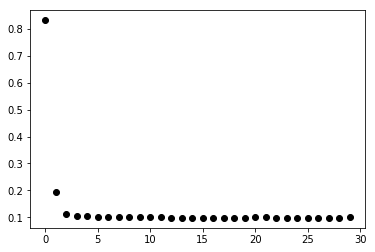

eps 0.8
ending 13


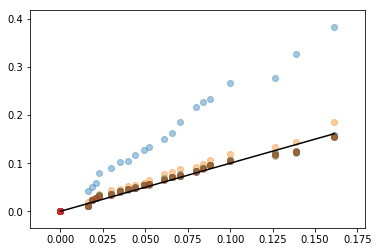

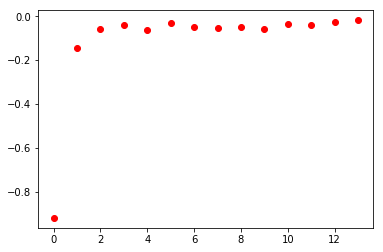

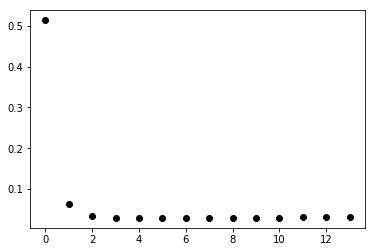

eps 1.2


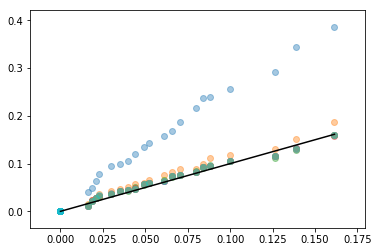

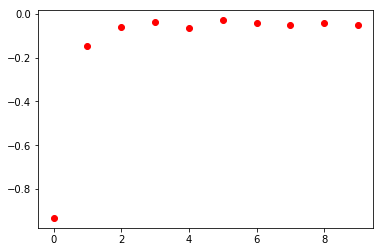

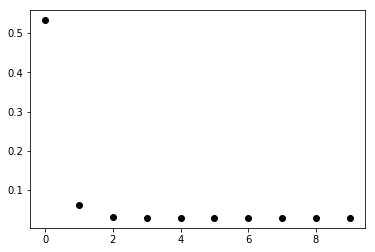

n_seq  30000
eps 0.4


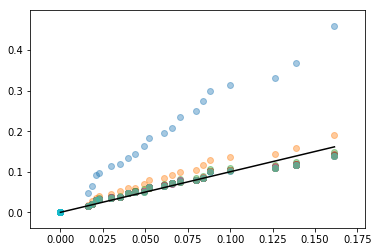

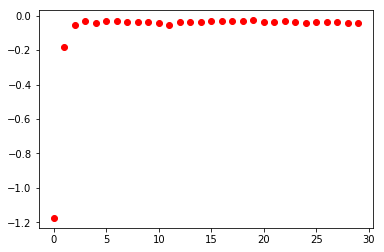

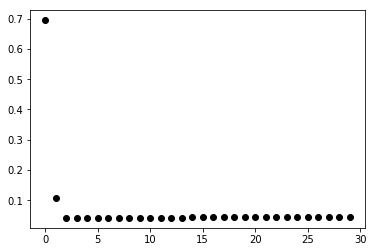

eps 0.8


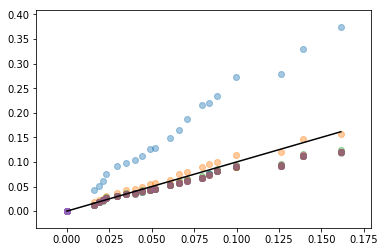

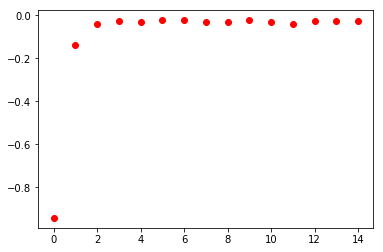

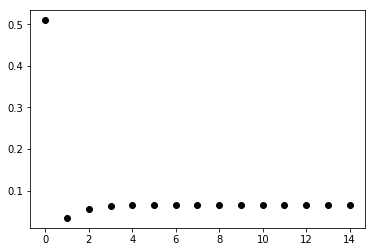

eps 1.2


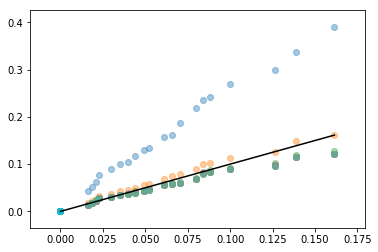

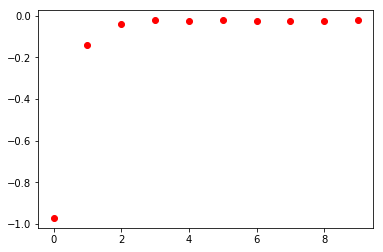

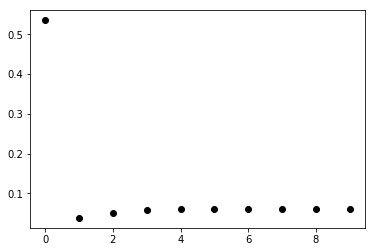

n_seq  50000
eps 0.4


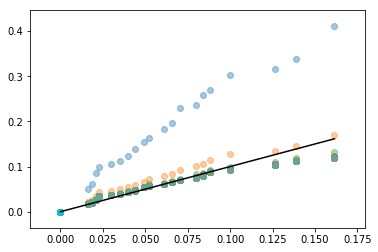

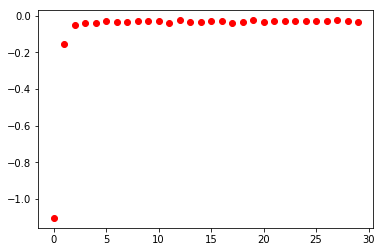

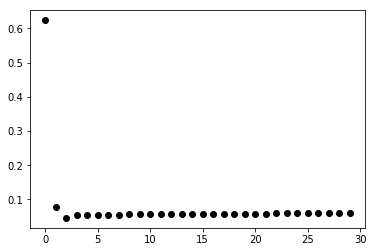

eps 0.8
ending 9


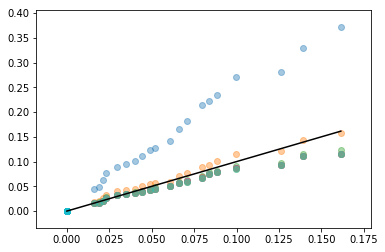

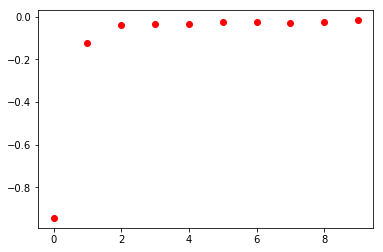

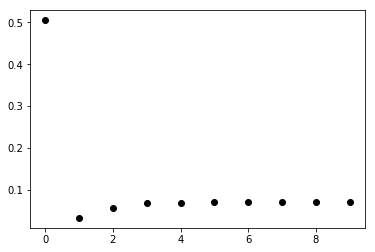

eps 1.2
ending 9


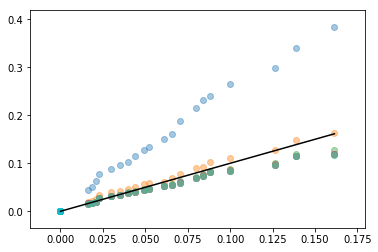

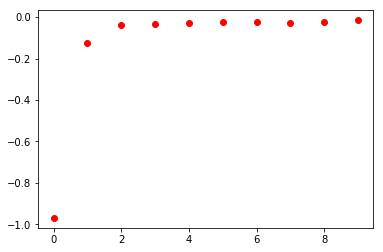

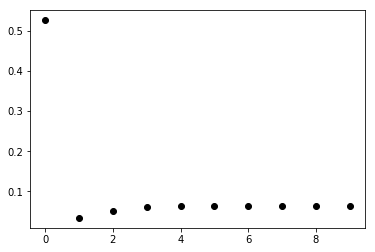

n_seq  70000
eps 0.4


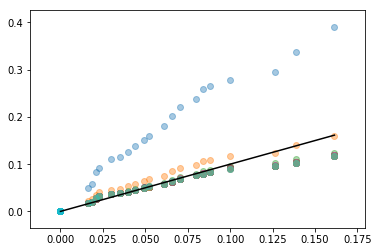

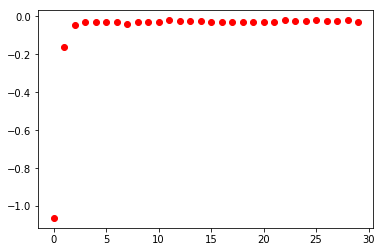

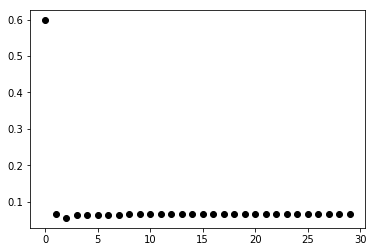

eps 0.8
ending 11


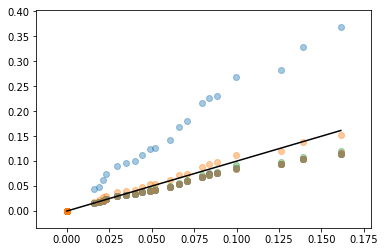

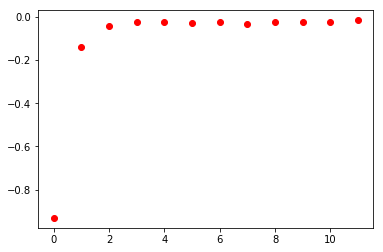

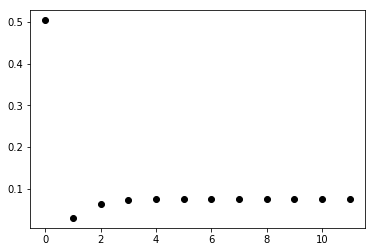

eps 1.2


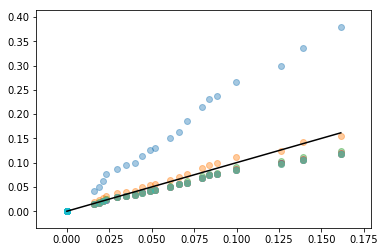

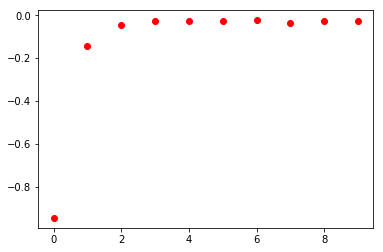

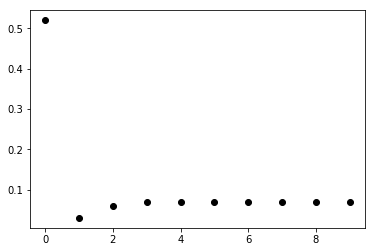

In [52]:
for n_part in range(10000,80001,20000):
    print('n_seq ',n_part)
    for eps in [0.4,0.8,1.2]:
        print('eps',eps)

        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = (np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5)/2.
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=int(12/eps),eps_scale=eps,RBM=RBM0)





In [6]:
# def tau_update(n_seq,n_var,RBM,ops,w): #directly use the expected value of tau
#     sigma_i = ops[:,:n_var-RBM]
#     tau_A =  ops[:,n_var-RBM:n_var]
#     w_iA = (w[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
#     v_A = (w[n_var-RBM:n_var].reshape((RBM)))
#     u_i = (w[:n_var-RBM].reshape((n_var-RBM)))
#     rand = np.random.rand(n_seq,RBM)
#     alt_tau = np.random.choice([1,-1],size=(n_seq,RBM))
#     tau_temp = 1.0/(1.0+np.exp((tau_A - alt_tau)*sigma_i.dot(w_iA)))
#     rand_choice = tau_temp >= rand # present tau_A[index] is less likely
#     s_temp = np.copy(ops[:,:n_var])
#     s_temp[:,n_var-RBM:n_var] = alt_tau
#     return operators(s_temp,RBM=RBM)



In [10]:
for n_part in range(10000,80001,15000):
    print('n_seq ',n_part)
    print('rbm_EM ')
    for eps in [0.1,0.2,0.3,0.4]:
        np.random.seed(13)
        if RBM0 == 0:
            w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) -0.5
        else:
            w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0)-0.5
        eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=int(12/eps),eps_scale=eps,RBM=RBM0)




n_seq  10000
rbm_EM 


ValueError: too many values to unpack (expected 3)